In [7]:
!pip install -q kaggle scikit-learn matplotlib seaborn pandas numpy scipy Pillow
!pip install -q openTSNE

print("Dependencias instaladas")

# ============================================================================
# 1. ENCABEZADO Y CONFIGURACIONES
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
import warnings
warnings.filterwarnings('ignore')

# PIL para cargar imágenes
from PIL import Image

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             silhouette_score, davies_bouldin_score,
                             confusion_matrix)
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from scipy.stats import ttest_rel, wilcoxon
from scipy.cluster.hierarchy import dendrogram, linkage

import json
import os
from collections import Counter

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("="*70)
print("ANÁLISIS COMPARATIVO: t-SNE + DBSCAN vs GMM en MNIST")
print("="*70)

# ============================================================================
# PARÁMETROS GLOBALES CONFIGURABLES
# ============================================================================
PARAMS = {
    'n_samples': 10000,  # Subsample para Colab (usar 60000 para dataset completo)
    'normalize': True,

    # Reproducibilidad
    'seeds': [0, 42, 99, 123, 2025],
    'n_runs': 5,

    # PCA
    'use_pca': True,
    'pca_n_components': 50,

    # t-SNE
    'tsne_perplexities': [30, 50],
    'tsne_learning_rates': [200, 500],
    'tsne_n_iter': 1000,
    'tsne_n_components': 2,

    # DBSCAN
    'dbscan_eps_range': np.arange(0.5, 5.0, 0.5),
    'dbscan_min_samples': [3, 5, 10],

    # GMM
    'gmm_n_components_range': range(2, 16),
    'gmm_covariance_types': ['full', 'diag'],

    # Evaluación
    'knn_k_values': [5, 10],

    # Visualización
    'sample_images_per_cluster': 10,
    'examples_to_show': 10
}

def set_seed(seed):
    """Fijar semilla para reproducibilidad"""
    np.random.seed(seed)

print(f"✓ Configuración cargada: {PARAMS['n_samples']} muestras, {PARAMS['n_runs']} runs")

Dependencias instaladas
ANÁLISIS COMPARATIVO: t-SNE + DBSCAN vs GMM en MNIST
✓ Configuración cargada: 10000 muestras, 5 runs


In [8]:
print("\n" + "="*70)
print("CONFIGURANDO KAGGLE API")
print("="*70)

kaggle_credentials = {
    "username": "criririris",
    "key": "a5338ed21f8e863031505de92b1022bb"
}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json
print("Credenciales configuradas")


CONFIGURANDO KAGGLE API
Credenciales configuradas


In [9]:
# ============================================================================
# 2. CARGA Y PREPROCESAMIENTO DEL DATASET
# ============================================================================
print("\n" + "="*70)
print("DESCARGANDO Y CARGANDO MNIST")
print("="*70)

# Descargar dataset
print("Descargando MNIST desde Kaggle...")
!kaggle datasets download -d hojjatk/mnist-dataset

print("\nDescomprimiendo archivos...")
!unzip -q -o mnist-dataset.zip -d mnist_data

print("Dataset descargado")

# Función para leer archivos IDX
def read_idx_images(filename):
    """Leer archivo de imágenes en formato IDX (MNIST)"""
    with open(filename, 'rb') as f:
        # Leer magic number y dimensiones
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')

        # Leer todas las imágenes
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows * num_cols)

    return images

def read_idx_labels(filename):
    """Leer archivo de etiquetas en formato IDX (MNIST)"""
    with open(filename, 'rb') as f:
        # Leer magic number y número de etiquetas
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')

        # Leer todas las etiquetas
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

def load_mnist_idx(base_path='mnist_data', split='train', n_samples=None):
    """Cargar MNIST desde archivos IDX"""

    print(f"\n→ Buscando archivos IDX en: {base_path}")

    # Buscar archivos en todas las ubicaciones posibles
    possible_image_paths = [
        os.path.join(base_path, 'train-images.idx3-ubyte'),
        os.path.join(base_path, 'train-images-idx3-ubyte', 'train-images-idx3-ubyte'),
        os.path.join(base_path, 'train-images-idx3-ubyte'),
    ]

    possible_label_paths = [
        os.path.join(base_path, 'train-labels.idx1-ubyte'),
        os.path.join(base_path, 'train-labels-idx1-ubyte', 'train-labels-idx1-ubyte'),
        os.path.join(base_path, 'train-labels-idx1-ubyte'),
    ]

    # Encontrar archivos existentes
    images_file = None
    labels_file = None

    for path in possible_image_paths:
        if os.path.exists(path):
            images_file = path
            print(f"✓ Imágenes encontradas: {path}")
            break

    for path in possible_label_paths:
        if os.path.exists(path):
            labels_file = path
            print(f"✓ Etiquetas encontradas: {path}")
            break

    if not images_file or not labels_file:
        raise FileNotFoundError(
            f"No se encontraron los archivos IDX.\n"
            f"Buscados en: {base_path}\n"
            f"Archivos disponibles: {os.listdir(base_path)}"
        )

    # Leer datos
    print(f"\n→ Leyendo archivos IDX...")
    images = read_idx_images(images_file)
    labels = read_idx_labels(labels_file)

    print(f"Leídos {len(images)} imágenes, {len(labels)} etiquetas")

    if n_samples and n_samples < len(images):
        print(f"\n→ Submuestreando {n_samples} de {len(images)} imágenes...")
        indices = np.random.choice(len(images), n_samples, replace=False)
        images = images[indices]
        labels = labels[indices]
        print(f"Submuestreo completado: {len(images)} muestras")

    return images, labels

# Cargar datos
try:
    print("\n→ Cargando datos de entrenamiento...")
    X_raw, y = load_mnist_idx('mnist_data', split='train', n_samples=PARAMS['n_samples'])
except Exception as e:
    print(f"Error: {e}")
    print("\n→ Listando archivos disponibles:")
    for root, dirs, files in os.walk('mnist_data'):
        level = root.replace('mnist_data', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f'{subindent}{file}')
    raise

# Normalizar a [0, 1]
if PARAMS['normalize']:
    X_normalized = X_raw / 255.0
else:
    X_normalized = X_raw.copy()

print(f"\n{'='*70}")
print(f"DATOS CARGADOS EXITOSAMENTE")
print(f"{'='*70}")
print(f"  Forma: {X_normalized.shape}")
print(f"  Tipo de dato: {X_normalized.dtype}")
print(f"  Rango: [{X_normalized.min():.2f}, {X_normalized.max():.2f}]")
print(f"  Clases únicas: {np.unique(y)}")
print(f"\n  Distribución de clases:")
class_distribution = pd.Series(y).value_counts().sort_index()
for digit, count in class_distribution.items():
    print(f"    Dígito {digit}: {count:5d} muestras ({count/len(y)*100:.1f}%)")
print(f"{'='*70}")


DESCARGANDO Y CARGANDO MNIST
Descargando MNIST desde Kaggle...
Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
mnist-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)

Descomprimiendo archivos...
Dataset descargado

→ Cargando datos de entrenamiento...

→ Buscando archivos IDX en: mnist_data
✓ Imágenes encontradas: mnist_data/train-images.idx3-ubyte
✓ Etiquetas encontradas: mnist_data/train-labels.idx1-ubyte

→ Leyendo archivos IDX...
Leídos 60000 imágenes, 60000 etiquetas

→ Submuestreando 10000 de 60000 imágenes...
Submuestreo completado: 10000 muestras

DATOS CARGADOS EXITOSAMENTE
  Forma: (10000, 784)
  Tipo de dato: float64
  Rango: [0.00, 1.00]
  Clases únicas: [0 1 2 3 4 5 6 7 8 9]

  Distribución de clases:
    Dígito 0:  1022 muestras (10.2%)
    Dígito 1:  1107 muestras (11.1%)
    Dígito 2:   951 muestras (9.5%)
    Dígito 3:  1033 muestras (10.3%)
    Dígito 4:  1004 muestras (10.


ANÁLISIS EXPLORATORIO INICIAL

Estadísticas de intensidad de píxeles:
Media: 0.1305
Desv. Std: 0.3080
Min: 0.0000
Max: 1.0000


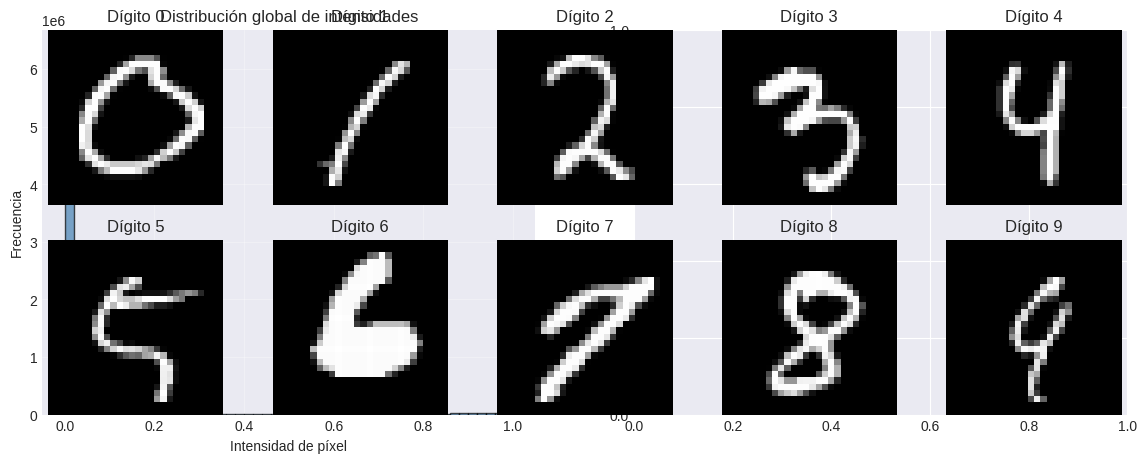


Intensidad media y desviación por clase:
 digit  mean_intensity  std_intensity  count
     0        0.171878       0.346424   1022
     1        0.075518       0.243415   1107
     2        0.147831       0.324754    951
     3        0.140788       0.317188   1033
     4        0.122551       0.298950   1004
     5        0.127473       0.302243    885
     6        0.138499       0.316263    989
     7        0.114013       0.291298   1025
     8        0.150041       0.324883   1022
     9        0.121580       0.297517    962


In [10]:
print("\n" + "="*70)
print("ANÁLISIS EXPLORATORIO INICIAL")
print("="*70)

print("\nEstadísticas de intensidad de píxeles:")
print(f"Media: {X_normalized.mean():.4f}")
print(f"Desv. Std: {X_normalized.std():.4f}")
print(f"Min: {X_normalized.min():.4f}")
print(f"Max: {X_normalized.max():.4f}")

# Histograma global de intensidades
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(X_normalized.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Intensidad de píxel')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución global de intensidades')
axes[0].grid(True, alpha=0.3)

# Mosaico de ejemplos por clase
sample_indices = []
for digit in range(10):
    digit_indices = np.where(y == digit)[0]
    sample_indices.append(np.random.choice(digit_indices, 1)[0])

for i, idx in enumerate(sample_indices):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(X_raw[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Dígito {y[idx]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Estadísticas por clase
print("\nIntensidad media y desviación por clase:")
stats_per_class = []
for digit in range(10):
    digit_data = X_normalized[y == digit]
    stats_per_class.append({
        'digit': digit,
        'mean_intensity': digit_data.mean(),
        'std_intensity': digit_data.std(),
        'count': len(digit_data)
    })

df_stats = pd.DataFrame(stats_per_class)
print(df_stats.to_string(index=False))


ANÁLISIS EXPLORATORIO: PCA


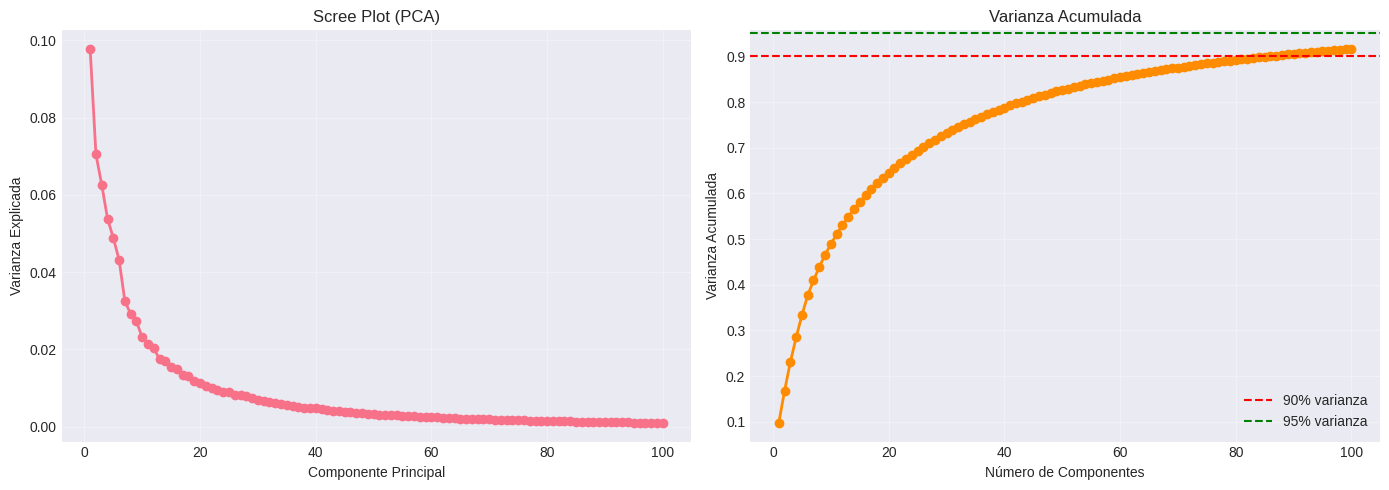


✓ Componentes para 90% varianza: 86
✓ Componentes para 95% varianza: 1
✓ Usando 50 componentes: 82.62% varianza


In [11]:
# ============================================================================
# 3. ANÁLISIS EXPLORATORIO EN ALTA DIMENSIÓN (PCA)
# ============================================================================
print("\n" + "="*70)
print("ANÁLISIS EXPLORATORIO: PCA")
print("="*70)

# Scree plot
pca_full = PCA(n_components=100)
pca_full.fit(X_normalized)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Explained variance
axes[0].plot(range(1, 101), pca_full.explained_variance_ratio_, 'o-', linewidth=2)
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Scree Plot (PCA)')
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, 101), cumsum, 'o-', linewidth=2, color='darkorange')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% varianza')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% varianza')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada')
axes[1].set_title('Varianza Acumulada')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_for_90 = np.argmax(cumsum >= 0.90) + 1
n_for_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\n✓ Componentes para 90% varianza: {n_for_90}")
print(f"✓ Componentes para 95% varianza: {n_for_95}")
print(f"✓ Usando {PARAMS['pca_n_components']} componentes: {cumsum[PARAMS['pca_n_components']-1]*100:.2f}% varianza")

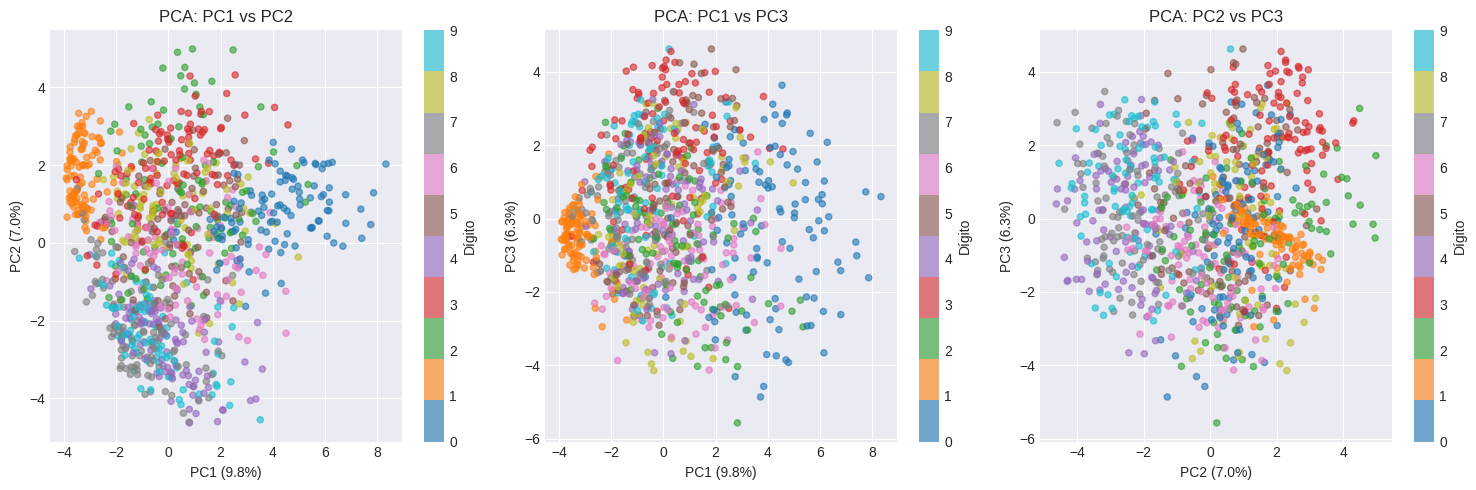

In [12]:
# PCA 3D scatter (primeras 3 componentes)
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(X_normalized)

# Tomar muestra para visualización
sample_size = 1000
sample_idx = np.random.choice(len(X_pca3), sample_size, replace=False)

fig = plt.figure(figsize=(15, 5))

# PC1 vs PC2
ax1 = fig.add_subplot(131)
scatter1 = ax1.scatter(X_pca3[sample_idx, 0], X_pca3[sample_idx, 1],
                       c=y[sample_idx], cmap='tab10', alpha=0.6, s=20)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('PCA: PC1 vs PC2')
plt.colorbar(scatter1, ax=ax1, label='Dígito')

# PC1 vs PC3
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(X_pca3[sample_idx, 0], X_pca3[sample_idx, 2],
                       c=y[sample_idx], cmap='tab10', alpha=0.6, s=20)
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
ax2.set_title('PCA: PC1 vs PC3')
plt.colorbar(scatter2, ax=ax2, label='Dígito')

# PC2 vs PC3
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(X_pca3[sample_idx, 1], X_pca3[sample_idx, 2],
                       c=y[sample_idx], cmap='tab10', alpha=0.6, s=20)
ax3.set_xlabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax3.set_ylabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
ax3.set_title('PCA: PC2 vs PC3')
plt.colorbar(scatter3, ax=ax3, label='Dígito')

plt.tight_layout()
plt.show()

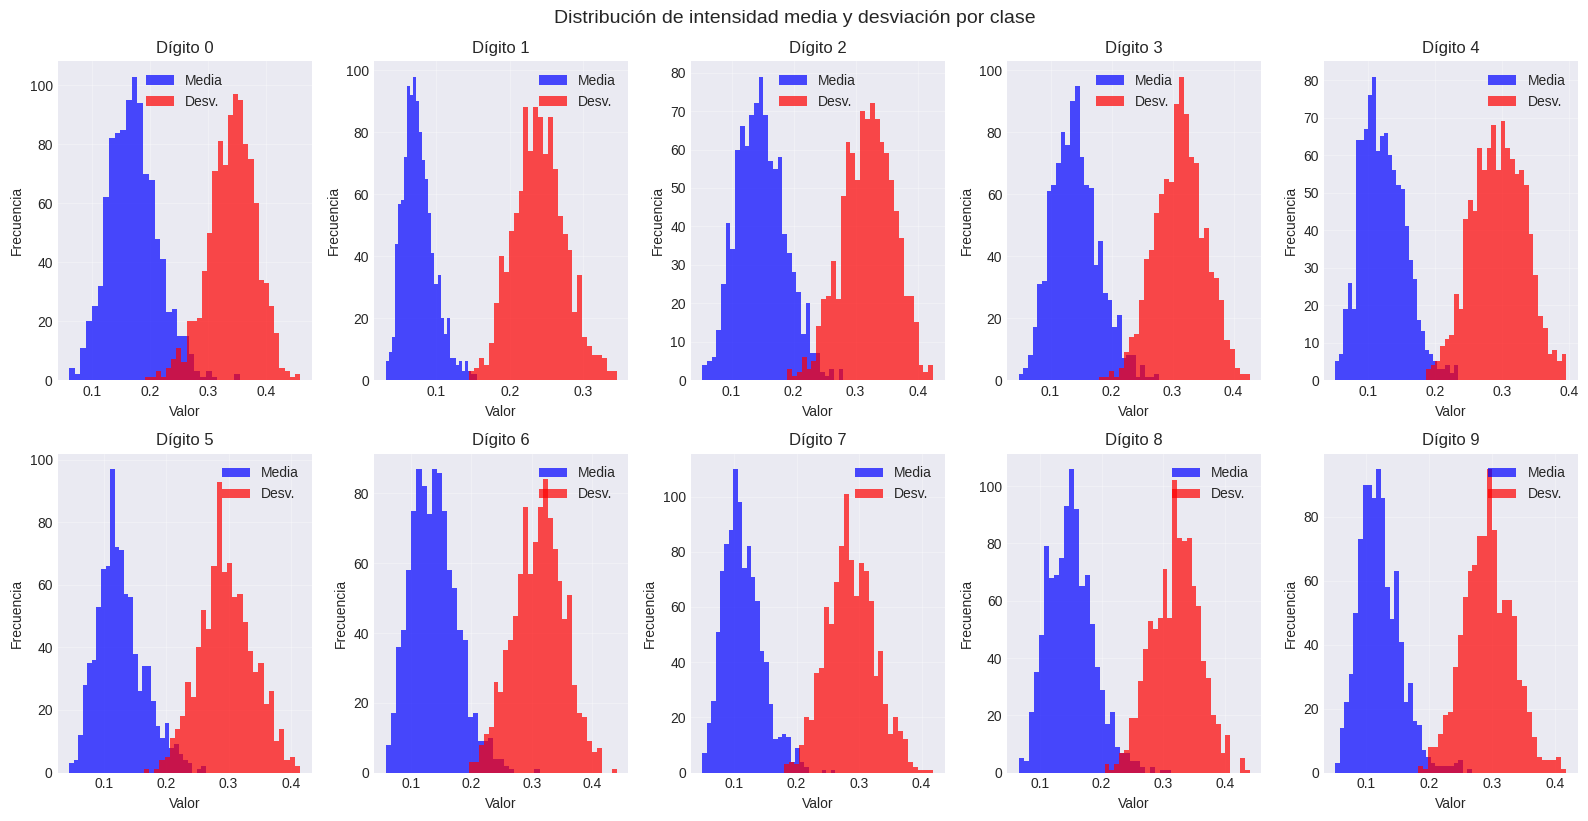

In [13]:
# Histogramas de intensidad por clase
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.flatten()

for digit in range(10):
    digit_data = X_normalized[y == digit]
    mean_per_sample = digit_data.mean(axis=1)
    std_per_sample = digit_data.std(axis=1)

    axes[digit].hist(mean_per_sample, bins=30, alpha=0.7, label='Media', color='blue')
    axes[digit].hist(std_per_sample, bins=30, alpha=0.7, label='Desv.', color='red')
    axes[digit].set_title(f'Dígito {digit}')
    axes[digit].set_xlabel('Valor')
    axes[digit].set_ylabel('Frecuencia')
    axes[digit].legend()
    axes[digit].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribución de intensidad media y desviación por clase', y=1.02, fontsize=14)
plt.show()


REDUCCIÓN DIMENSIONAL: PCA + t-SNE

→ Aplicando PCA a 50 componentes...
✓ PCA completado en 1.77s
  Varianza explicada: 82.62%


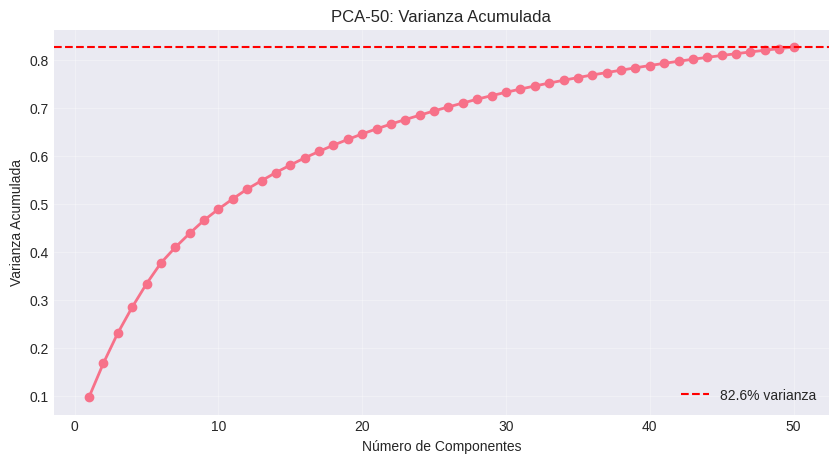


→ Ejecutando t-SNE con múltiples configuraciones...
  Perplexities: [30, 50]
  Learning rates: [200, 500]

  Configuración: perplexity=30, lr=200
  ✓ Completado en 149.57s

  Configuración: perplexity=30, lr=500
  ✓ Completado en 131.24s

  Configuración: perplexity=50, lr=200
  ✓ Completado en 144.38s

  Configuración: perplexity=50, lr=500
  ✓ Completado en 139.15s

t-SNE completado para todas las configuraciones
✓ Usando 'perp30_lr200' como configuración base


In [14]:
# ============================================================================
# 4. EMBEDDINGS: PCA Y t-SNE
# ============================================================================
print("\n" + "="*70)
print("REDUCCIÓN DIMENSIONAL: PCA + t-SNE")
print("="*70)

# Aplicar PCA si está configurado
if PARAMS['use_pca']:
    print(f"\n→ Aplicando PCA a {PARAMS['pca_n_components']} componentes...")
    start = perf_counter()
    pca = PCA(n_components=PARAMS['pca_n_components'], random_state=42)
    X_pca = pca.fit_transform(X_normalized)
    time_pca = perf_counter() - start

    print(f"✓ PCA completado en {time_pca:.2f}s")
    print(f"  Varianza explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")

    # Gráfica de varianza acumulada para PCA50
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    cumsum_pca = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cumsum_pca)+1), cumsum_pca, 'o-', linewidth=2)
    ax.axhline(y=cumsum_pca[-1], color='r', linestyle='--',
               label=f'{cumsum_pca[-1]*100:.1f}% varianza')
    ax.set_xlabel('Número de Componentes')
    ax.set_ylabel('Varianza Acumulada')
    ax.set_title(f'PCA-{PARAMS["pca_n_components"]}: Varianza Acumulada')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

    X_for_tsne = X_pca
else:
    X_for_tsne = X_normalized
    print("Usando datos originales normalizados para t-SNE")

# Almacenar embeddings t-SNE
tsne_embeddings = {}
tsne_times = {}

print(f"\n→ Ejecutando t-SNE con múltiples configuraciones...")
print(f"  Perplexities: {PARAMS['tsne_perplexities']}")
print(f"  Learning rates: {PARAMS['tsne_learning_rates']}")

for perp in PARAMS['tsne_perplexities']:
    for lr in PARAMS['tsne_learning_rates']:
        key = f"perp{perp}_lr{lr}"
        print(f"\n  Configuración: perplexity={perp}, lr={lr}")

        start = perf_counter()
        tsne = TSNE(n_components=PARAMS['tsne_n_components'],
                   perplexity=perp,
                   learning_rate=lr,
                   n_iter=PARAMS['tsne_n_iter'],
                   random_state=42,
                   verbose=0)
        X_tsne = tsne.fit_transform(X_for_tsne)
        elapsed = perf_counter() - start

        tsne_embeddings[key] = X_tsne
        tsne_times[key] = elapsed

        print(f"  ✓ Completado en {elapsed:.2f}s")

# Usar configuración base para análisis principal
base_key = f"perp{PARAMS['tsne_perplexities'][0]}_lr{PARAMS['tsne_learning_rates'][0]}"
X_tsne_base = tsne_embeddings[base_key]

print(f"\nt-SNE completado para todas las configuraciones")
print(f"✓ Usando '{base_key}' como configuración base")

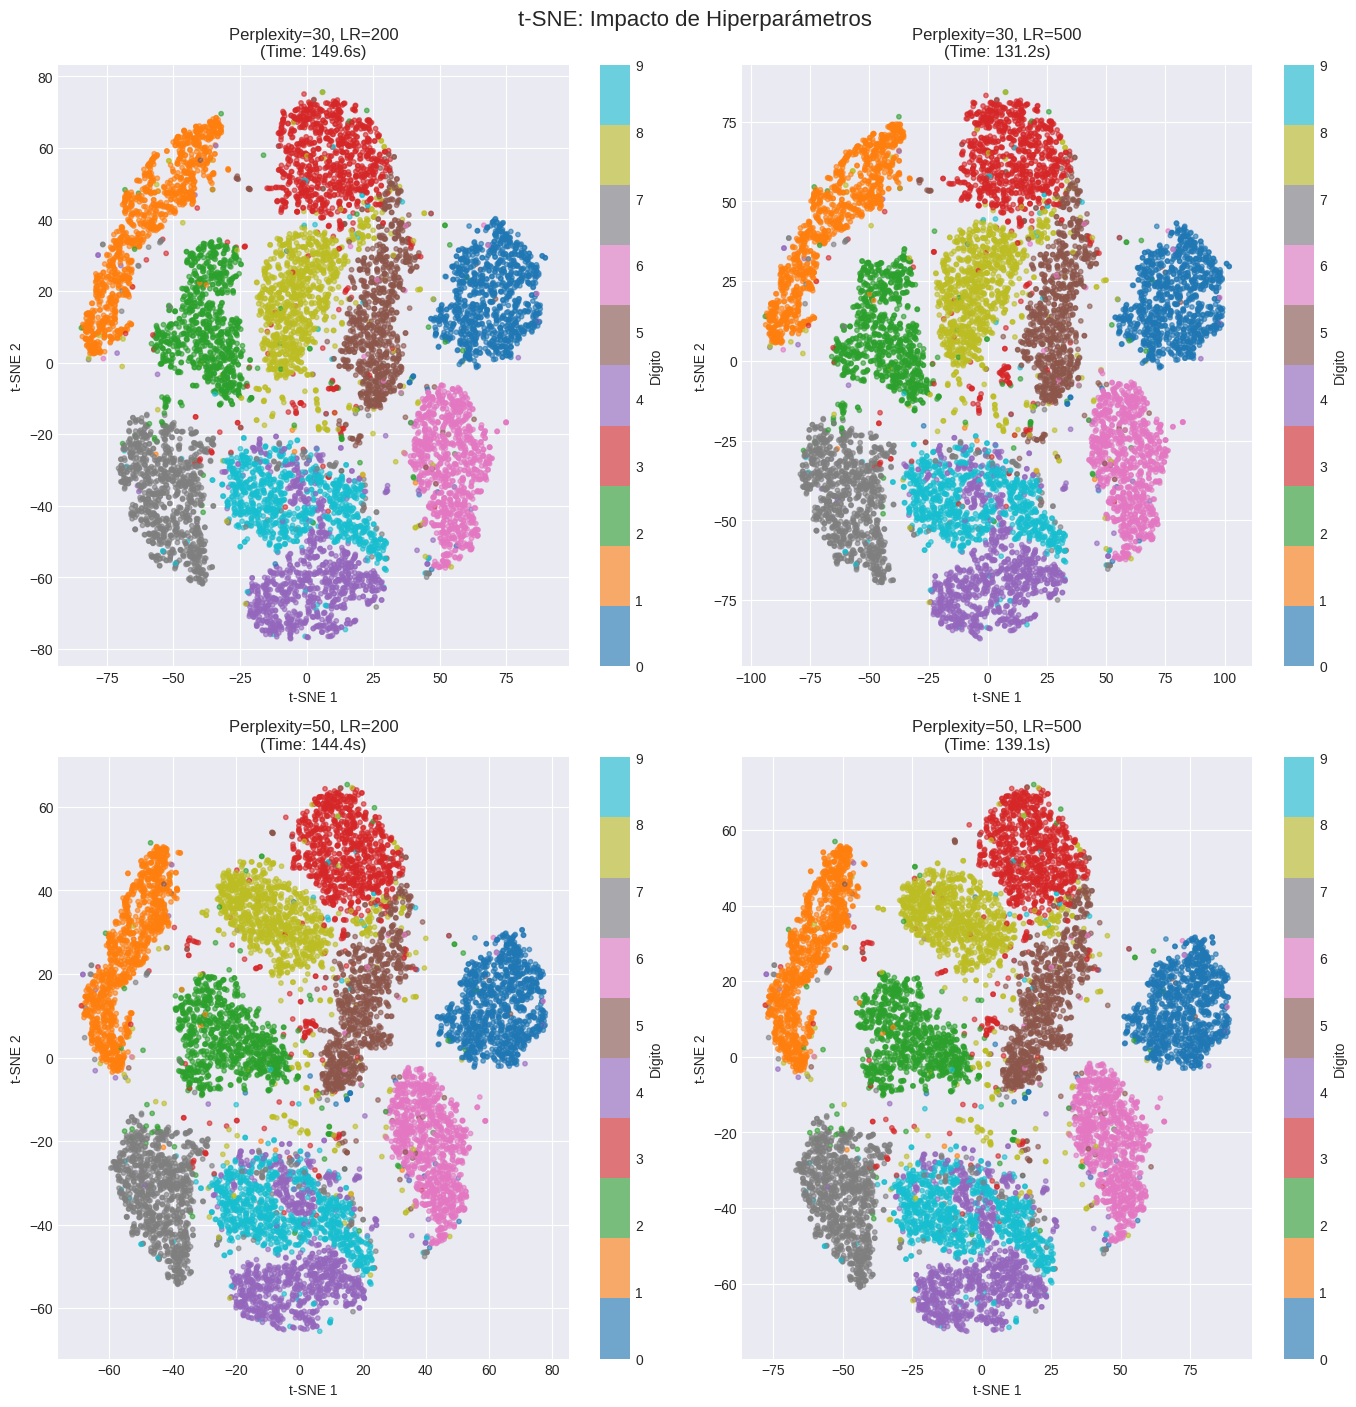

In [15]:
# Visualización: Grid de t-SNE con diferentes hiperparámetros
n_perp = len(PARAMS['tsne_perplexities'])
n_lr = len(PARAMS['tsne_learning_rates'])

fig, axes = plt.subplots(n_perp, n_lr, figsize=(7*n_lr, 7*n_perp))
if n_perp == 1 and n_lr == 1:
    axes = np.array([[axes]])
elif n_perp == 1:
    axes = axes.reshape(1, -1)
elif n_lr == 1:
    axes = axes.reshape(-1, 1)

for i, perp in enumerate(PARAMS['tsne_perplexities']):
    for j, lr in enumerate(PARAMS['tsne_learning_rates']):
        key = f"perp{perp}_lr{lr}"
        X_tsne = tsne_embeddings[key]

        scatter = axes[i, j].scatter(X_tsne[:, 0], X_tsne[:, 1],
                                     c=y, cmap='tab10', alpha=0.6, s=10)
        axes[i, j].set_title(f'Perplexity={perp}, LR={lr}\n(Time: {tsne_times[key]:.1f}s)')
        axes[i, j].set_xlabel('t-SNE 1')
        axes[i, j].set_ylabel('t-SNE 2')
        plt.colorbar(scatter, ax=axes[i, j], label='Dígito')

plt.tight_layout()
plt.suptitle('t-SNE: Impacto de Hiperparámetros', y=1.002, fontsize=16)
plt.show()

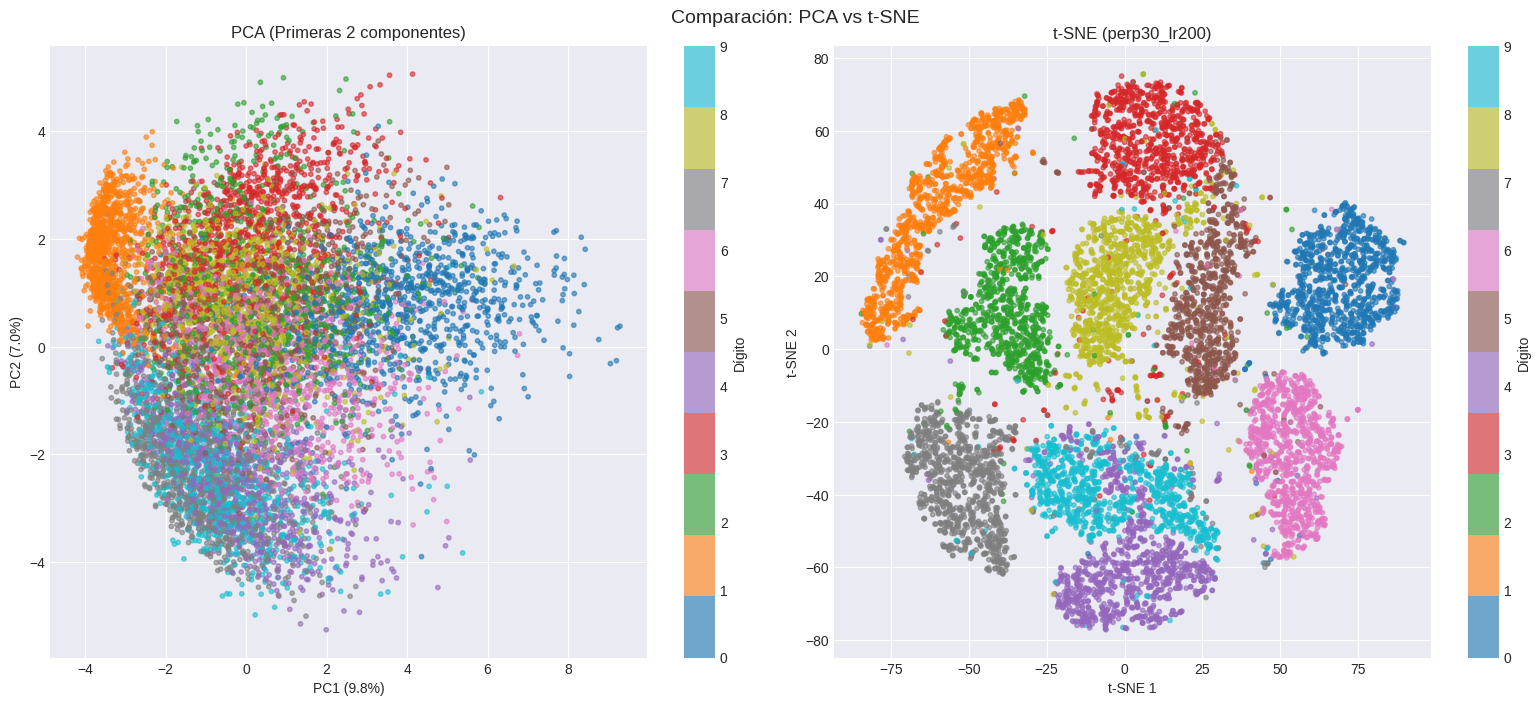

In [16]:
# Comparación antes/después: PCA vs t-SNE
if PARAMS['use_pca']:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # PCA (PC1 vs PC2)
    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    axes[0].set_title('PCA (Primeras 2 componentes)')
    plt.colorbar(scatter1, ax=axes[0], label='Dígito')

    # t-SNE
    scatter2 = axes[1].scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                               c=y, cmap='tab10', alpha=0.6, s=10)
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    axes[1].set_title(f't-SNE ({base_key})')
    plt.colorbar(scatter2, ax=axes[1], label='Dígito')

    plt.tight_layout()
    plt.suptitle('Comparación: PCA vs t-SNE', y=1.002, fontsize=14)
    plt.show()


EVALUACIÓN DE PRESERVACIÓN DE ESTRUCTURA
k-NN Preservation (k=5): 0.402
k-NN Preservation (k=10): 0.452


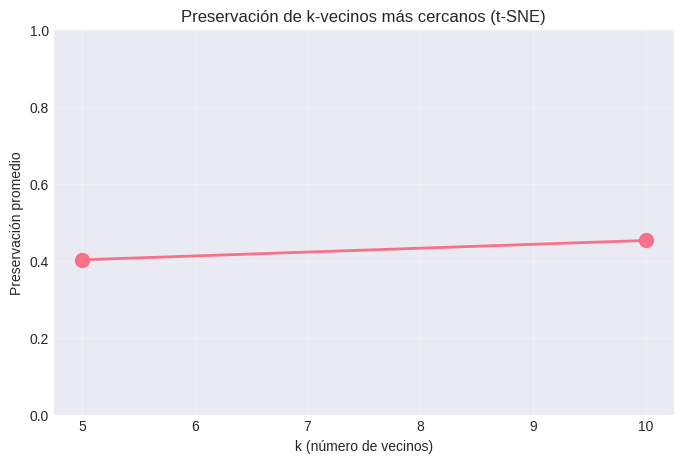

In [17]:
# ============================================================================
# 5. MEDIDAS DE PRESERVACIÓN LOCAL/GLOBAL
# ============================================================================
print("\n" + "="*70)
print("EVALUACIÓN DE PRESERVACIÓN DE ESTRUCTURA")
print("="*70)

def knn_preservation(X_original, X_embedded, k=5, n_samples=1000):
    """Calcular preservación de k-vecinos más cercanos"""
    # Tomar muestra para eficiencia
    idx = np.random.choice(len(X_original), min(n_samples, len(X_original)), replace=False)
    X_orig_sample = X_original[idx]
    X_emb_sample = X_embedded[idx]

    # Encontrar k-vecinos en espacio original
    nn_orig = NearestNeighbors(n_neighbors=k+1).fit(X_orig_sample)
    _, indices_orig = nn_orig.kneighbors(X_orig_sample)

    # Encontrar k-vecinos en espacio embebido
    nn_emb = NearestNeighbors(n_neighbors=k+1).fit(X_emb_sample)
    _, indices_emb = nn_emb.kneighbors(X_emb_sample)

    # Calcular solapamiento (excluyendo el punto mismo)
    preservations = []
    for i in range(len(X_orig_sample)):
        neighbors_orig = set(indices_orig[i, 1:])
        neighbors_emb = set(indices_emb[i, 1:])
        overlap = len(neighbors_orig & neighbors_emb)
        preservations.append(overlap / k)

    return np.mean(preservations)

# Calcular preservación k-NN
knn_results = {}
for k in PARAMS['knn_k_values']:
    preservation = knn_preservation(X_for_tsne, X_tsne_base, k=k, n_samples=1000)
    knn_results[f'k={k}'] = preservation
    print(f"k-NN Preservation (k={k}): {preservation:.3f}")

# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(PARAMS['knn_k_values'], [knn_results[f'k={k}'] for k in PARAMS['knn_k_values']],
        'o-', linewidth=2, markersize=10)
ax.set_xlabel('k (número de vecinos)')
ax.set_ylabel('Preservación promedio')
ax.set_title('Preservación de k-vecinos más cercanos (t-SNE)')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])
plt.show()


→ Calculando distancias intra/inter-clase...

Espacio original (PCA50):
  Distancia intra-clase: 7.924 ± 1.808
  Distancia inter-clase: 9.377 ± 1.377
  Ratio inter/intra: 1.183

Espacio t-SNE:
  Distancia intra-clase: 23.853 ± 17.307
  Distancia inter-clase: 77.557 ± 31.895
  Ratio inter/intra: 3.251


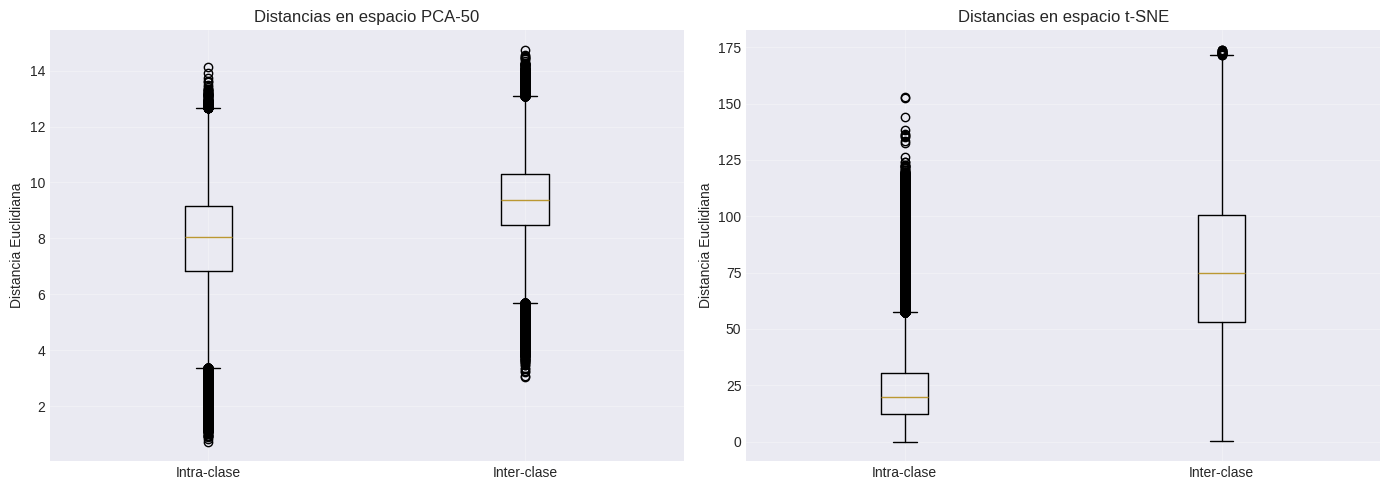

In [18]:
# Distancias intra-clase vs inter-clase
def compute_class_distances(X, labels):
    """Calcular distancias intra e inter-clase"""
    intra_distances = []
    inter_distances = []

    unique_classes = np.unique(labels)

    for cls in unique_classes:
        cls_idx = np.where(labels == cls)[0]
        other_idx = np.where(labels != cls)[0]

        # Tomar muestra si hay muchos puntos
        if len(cls_idx) > 200:
            cls_idx = np.random.choice(cls_idx, 200, replace=False)
        if len(other_idx) > 200:
            other_idx = np.random.choice(other_idx, 200, replace=False)

        # Intra-clase
        if len(cls_idx) > 1:
            cls_data = X[cls_idx]
            dist_matrix = cdist(cls_data, cls_data, 'euclidean')
            intra_distances.extend(dist_matrix[np.triu_indices_from(dist_matrix, k=1)])

        # Inter-clase
        cls_data = X[cls_idx]
        other_data = X[other_idx]
        inter_distances.extend(cdist(cls_data, other_data, 'euclidean').flatten())

    return np.array(intra_distances), np.array(inter_distances)

print("\n→ Calculando distancias intra/inter-clase...")
intra_orig, inter_orig = compute_class_distances(X_for_tsne, y)
intra_tsne, inter_tsne = compute_class_distances(X_tsne_base, y)

print(f"\nEspacio original (PCA{PARAMS['pca_n_components']}):")
print(f"  Distancia intra-clase: {intra_orig.mean():.3f} ± {intra_orig.std():.3f}")
print(f"  Distancia inter-clase: {inter_orig.mean():.3f} ± {inter_orig.std():.3f}")
print(f"  Ratio inter/intra: {inter_orig.mean() / intra_orig.mean():.3f}")

print(f"\nEspacio t-SNE:")
print(f"  Distancia intra-clase: {intra_tsne.mean():.3f} ± {intra_tsne.std():.3f}")
print(f"  Distancia inter-clase: {inter_tsne.mean():.3f} ± {inter_tsne.std():.3f}")
print(f"  Ratio inter/intra: {inter_tsne.mean() / intra_tsne.mean():.3f}")

# Boxplots comparativos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

data_to_plot = [intra_orig, inter_orig]
axes[0].boxplot(data_to_plot, labels=['Intra-clase', 'Inter-clase'])
axes[0].set_ylabel('Distancia Euclidiana')
axes[0].set_title(f'Distancias en espacio PCA-{PARAMS["pca_n_components"]}')
axes[0].grid(True, alpha=0.3)

data_to_plot = [intra_tsne, inter_tsne]
axes[1].boxplot(data_to_plot, labels=['Intra-clase', 'Inter-clase'])
axes[1].set_ylabel('Distancia Euclidiana')
axes[1].set_title('Distancias en espacio t-SNE')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CLUSTERING: DBSCAN

 Generando k-distance plot...


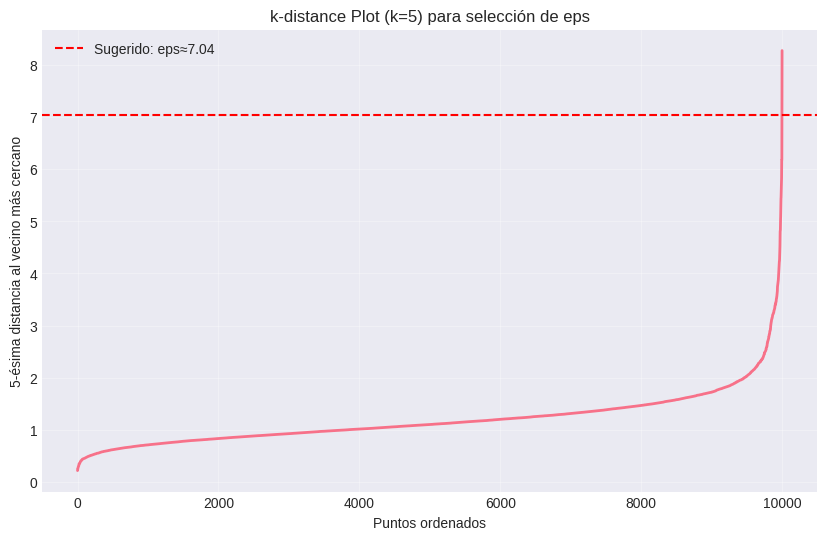

- Eps sugerido: 7.04

 Barrido de parámetros DBSCAN...

✓ 26 configuraciones evaluadas

Mejores 5 configuraciones por ARI:
    eps  min_samples  n_clusters  pct_outliers       ari       nmi  silhouette
9   2.0            5          46          2.63  0.853243  0.859445   -0.138755
8   2.0            3          77          1.35  0.798877  0.841289   -0.350937
13  2.5           10          18          3.33  0.754768  0.849879    0.052295
16  3.0           10          13          1.81  0.745972  0.843145    0.301861
12  2.5            5          26          1.55  0.741259  0.836267   -0.124043


In [19]:
# ============================================================================
# 6. DBSCAN: ANÁLISIS Y CLUSTERING
# ============================================================================
print("\n" + "="*70)
print("CLUSTERING: DBSCAN")
print("="*70)

# k-distance plot para selección de eps
def plot_k_distance(X, k=5):
    """Graficar k-distance para ayudar a elegir eps"""
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    k_distances = distances[:, -1]
    k_distances_sorted = np.sort(k_distances)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(k_distances_sorted, linewidth=2)
    ax.set_xlabel('Puntos ordenados')
    ax.set_ylabel(f'{k}-ésima distancia al vecino más cercano')
    ax.set_title(f'k-distance Plot (k={k}) para selección de eps')
    ax.grid(True, alpha=0.3)

    # Sugerir eps basado en "elbow" o metodo del codo
    gradient = np.gradient(k_distances_sorted)
    knee_idx = np.argmax(gradient)
    suggested_eps = k_distances_sorted[knee_idx]
    ax.axhline(y=suggested_eps, color='r', linestyle='--',
               label=f'Sugerido: eps≈{suggested_eps:.2f}')
    ax.legend()
    plt.show()

    return suggested_eps

print("\n Generando k-distance plot...")
suggested_eps = plot_k_distance(X_tsne_base, k=5)
print(f"- Eps sugerido: {suggested_eps:.2f}")
# Barrido de parámetros DBSCAN
print("\n Barrido de parámetros DBSCAN...")

dbscan_results = []

for eps in PARAMS['dbscan_eps_range']:
    for min_samples in PARAMS['dbscan_min_samples']:
        try:
            start = perf_counter()
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_tsne_base)
            elapsed = perf_counter() - start

            # Filtrar outliers para métricas
            mask_inliers = clusters != -1

            if mask_inliers.sum() > 0:
                # Métricas
                ari = adjusted_rand_score(y[mask_inliers], clusters[mask_inliers])
                nmi = normalized_mutual_info_score(y[mask_inliers], clusters[mask_inliers])

                if len(np.unique(clusters[mask_inliers])) > 1:
                    sil = silhouette_score(X_tsne_base[mask_inliers], clusters[mask_inliers])
                    db = davies_bouldin_score(X_tsne_base[mask_inliers], clusters[mask_inliers])
                else:
                    sil = -1
                    db = -1

                n_clusters = len(np.unique(clusters[mask_inliers]))
                pct_outliers = (clusters == -1).sum() / len(clusters) * 100

                dbscan_results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'pct_outliers': pct_outliers,
                    'ari': ari,
                    'nmi': nmi,
                    'silhouette': sil,
                    'davies_bouldin': db,
                    'time': elapsed
                })
        except Exception as e:
            print(f"  Error con eps={eps}, min_samples={min_samples}: {e}")
            continue

df_dbscan = pd.DataFrame(dbscan_results)
print(f"\n✓ {len(df_dbscan)} configuraciones evaluadas")
print("\nMejores 5 configuraciones por ARI:")
print(df_dbscan.nlargest(5, 'ari')[['eps', 'min_samples', 'n_clusters',
                                      'pct_outliers', 'ari', 'nmi', 'silhouette']])

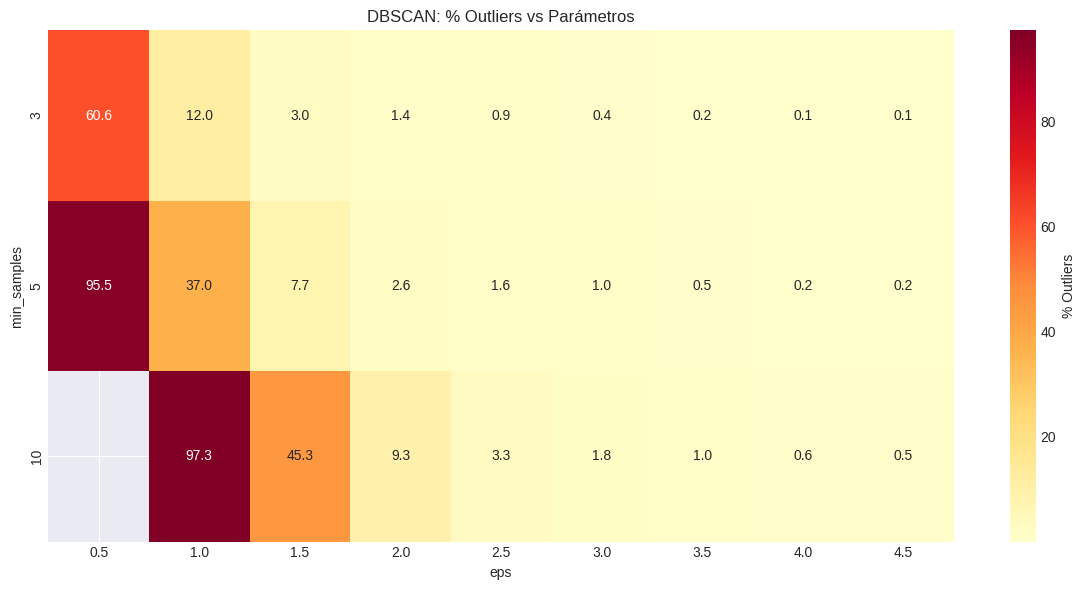

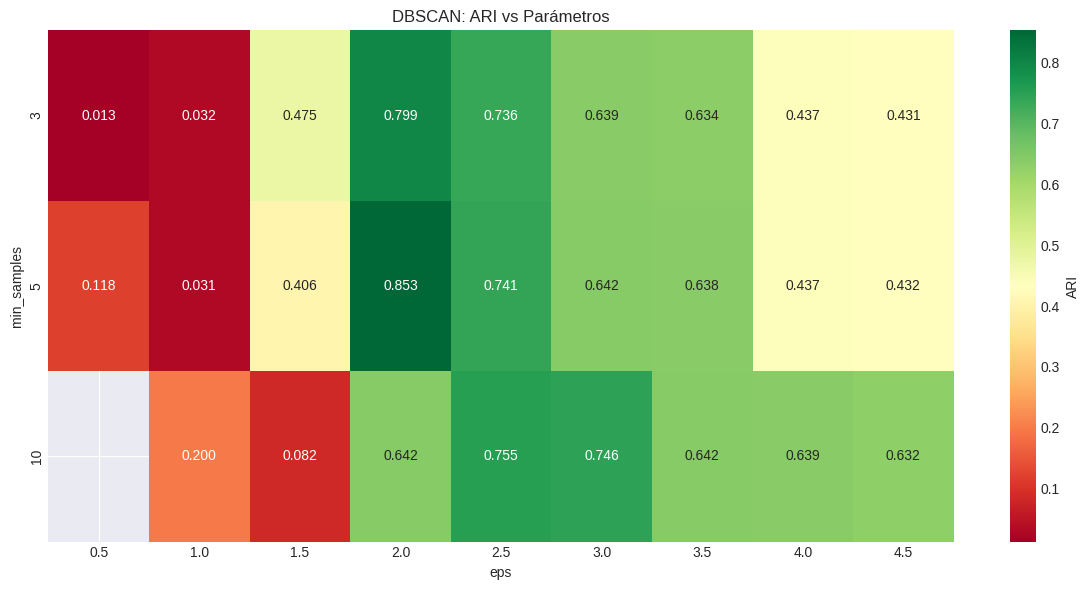

In [20]:
# Heatmap: % de outliers vs parámetros
pivot_outliers = df_dbscan.pivot_table(values='pct_outliers',
                                        index='min_samples',
                                        columns='eps')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.heatmap(pivot_outliers, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': '% Outliers'})
ax.set_title('DBSCAN: % Outliers vs Parámetros')
ax.set_xlabel('eps')
ax.set_ylabel('min_samples')
plt.tight_layout()
plt.show()

# Heatmap: ARI vs parámetros
pivot_ari = df_dbscan.pivot_table(values='ari', index='min_samples', columns='eps')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.heatmap(pivot_ari, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, cbar_kws={'label': 'ARI'})
ax.set_title('DBSCAN: ARI vs Parámetros')
ax.set_xlabel('eps')
ax.set_ylabel('min_samples')
plt.tight_layout()
plt.show()


→ Mejor configuración DBSCAN:
  eps=2.0, min_samples=5.0
  ARI=0.853, NMI=0.859
  Silhouette=-0.139
  Clusters=46, Outliers=2.6%


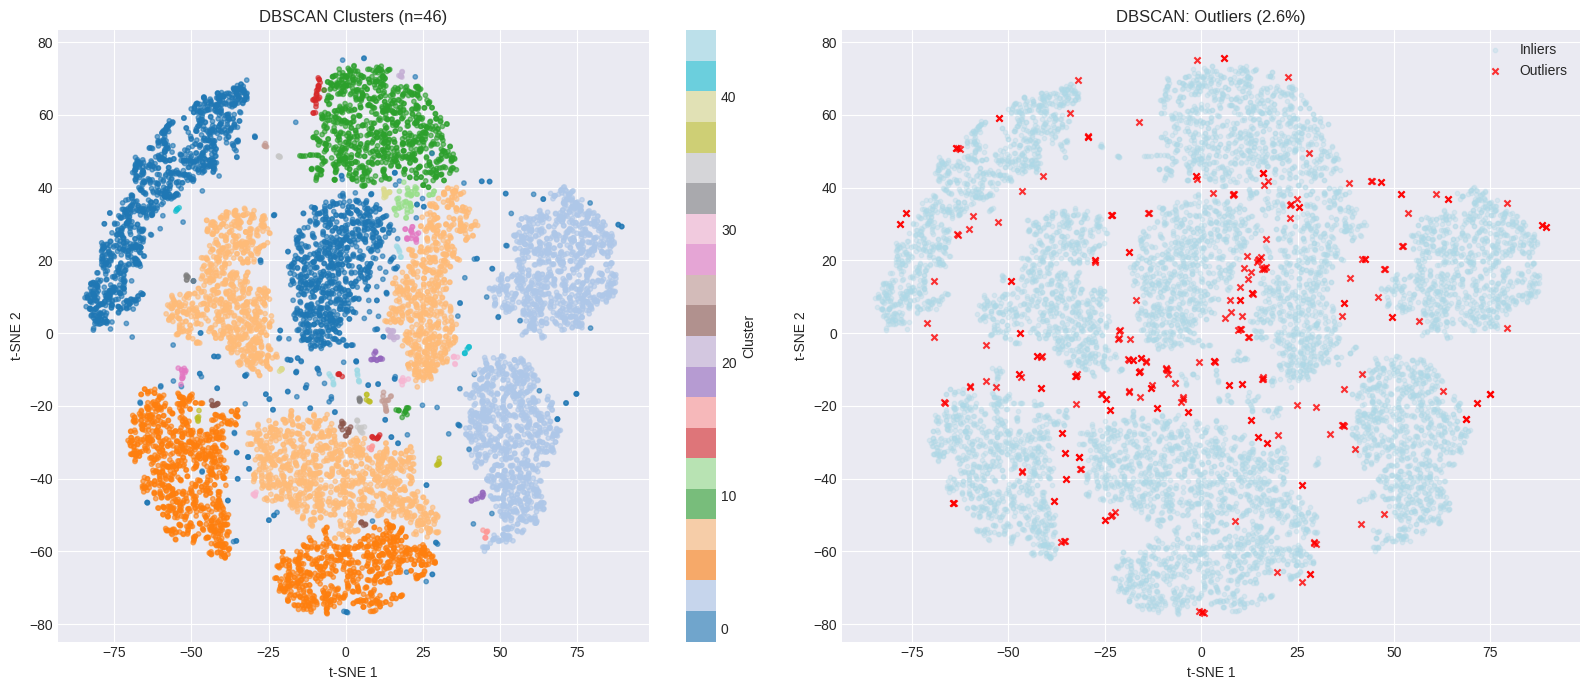

In [21]:
# Visualizar mejor configuración DBSCAN
best_dbscan = df_dbscan.loc[df_dbscan['ari'].idxmax()]
print(f"\n→ Mejor configuración DBSCAN:")
print(f"  eps={best_dbscan['eps']}, min_samples={best_dbscan['min_samples']}")
print(f"  ARI={best_dbscan['ari']:.3f}, NMI={best_dbscan['nmi']:.3f}")
print(f"  Silhouette={best_dbscan['silhouette']:.3f}")
print(f"  Clusters={int(best_dbscan['n_clusters'])}, Outliers={best_dbscan['pct_outliers']:.1f}%")

# Aplicar mejor configuración
dbscan_best = DBSCAN(eps=best_dbscan['eps'], min_samples=int(best_dbscan['min_samples']))
clusters_dbscan = dbscan_best.fit_predict(X_tsne_base)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Clusters coloreados
scatter1 = axes[0].scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                          c=clusters_dbscan, cmap='tab20', alpha=0.6, s=10)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'DBSCAN Clusters (n={int(best_dbscan["n_clusters"])})')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Destacar outliers
mask_outliers = clusters_dbscan == -1
axes[1].scatter(X_tsne_base[~mask_outliers, 0], X_tsne_base[~mask_outliers, 1],
               c='lightblue', alpha=0.3, s=10, label='Inliers')
axes[1].scatter(X_tsne_base[mask_outliers, 0], X_tsne_base[mask_outliers, 1],
               c='red', alpha=0.8, s=20, marker='x', label='Outliers')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title(f'DBSCAN: Outliers ({best_dbscan["pct_outliers"]:.1f}%)')
axes[1].legend()

plt.tight_layout()
plt.show()

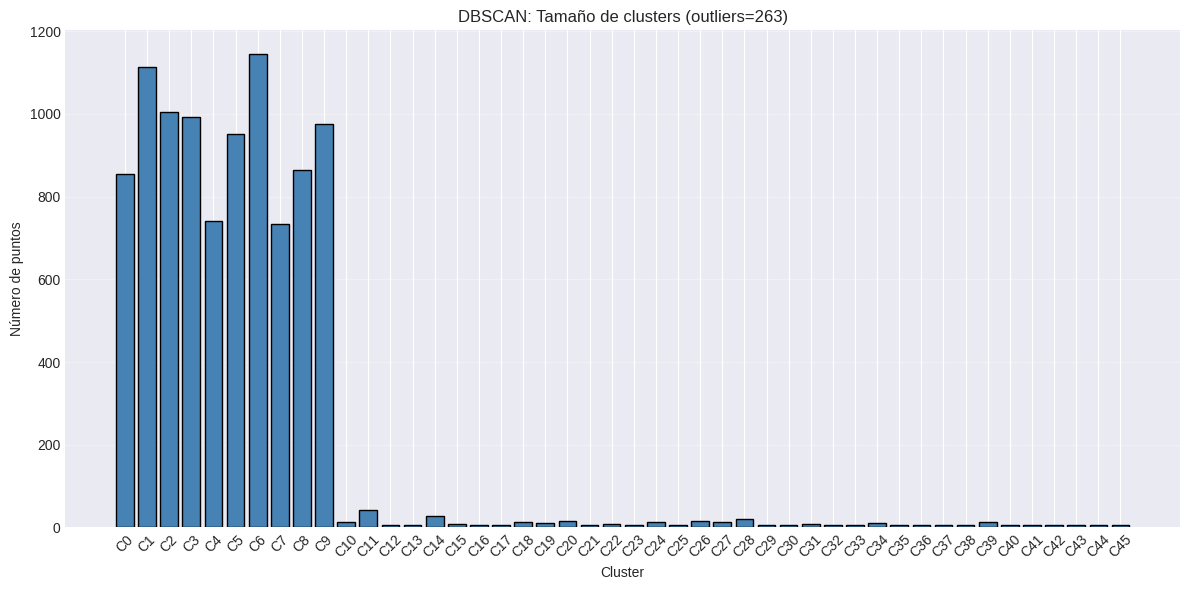

In [22]:
# Tamaños de clusters DBSCAN
cluster_counts = Counter(clusters_dbscan[clusters_dbscan != -1])
sorted_clusters = sorted(cluster_counts.items())

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
clusters_labels = [f'C{c}' for c, _ in sorted_clusters]
clusters_sizes = [s for _, s in sorted_clusters]
ax.bar(clusters_labels, clusters_sizes, color='steelblue', edgecolor='black')
ax.set_xlabel('Cluster')
ax.set_ylabel('Número de puntos')
ax.set_title(f'DBSCAN: Tamaño de clusters (outliers={mask_outliers.sum()})')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# ============================================================================
# 7. GMM (EM): AJUSTE Y EVALUACIÓN
# ============================================================================
print("\n" + "="*70)
print("CLUSTERING: GMM (EM)")
print("="*70)

# Sweep de n_components y covariance_type
gmm_results = []

print(f"\n→ Barrido de parámetros GMM...")
print(f"  n_components: {list(PARAMS['gmm_n_components_range'])}")
print(f"  covariance_types: {PARAMS['gmm_covariance_types']}")

for n_comp in PARAMS['gmm_n_components_range']:
    for cov_type in PARAMS['gmm_covariance_types']:
        try:
            start = perf_counter()
            gmm = GaussianMixture(n_components=n_comp,
                                 covariance_type=cov_type,
                                 random_state=42,
                                 max_iter=200)

            # Ajustar en PCA (más estable que t-SNE 2D)
            gmm.fit(X_pca)
            elapsed = perf_counter() - start

            # Predecir
            labels_gmm = gmm.predict(X_pca)

            # Métricas
            ari = adjusted_rand_score(y, labels_gmm)
            nmi = normalized_mutual_info_score(y, labels_gmm)

            if n_comp > 1:
                sil = silhouette_score(X_pca, labels_gmm)
                db = davies_bouldin_score(X_pca, labels_gmm)
            else:
                sil = -1
                db = -1

            bic = gmm.bic(X_pca)
            aic = gmm.aic(X_pca)

            gmm_results.append({
                'n_components': n_comp,
                'covariance_type': cov_type,
                'ari': ari,
                'nmi': nmi,
                'silhouette': sil,
                'davies_bouldin': db,
                'bic': bic,
                'aic': aic,
                'time': elapsed,
                'converged': gmm.converged_
            })

        except Exception as e:
            print(f"  Error con n_comp={n_comp}, cov_type={cov_type}: {e}")
            continue

df_gmm = pd.DataFrame(gmm_results)
print(f"\n✓ {len(df_gmm)} configuraciones evaluadas")


CLUSTERING: GMM (EM)

→ Barrido de parámetros GMM...
  n_components: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  covariance_types: ['full', 'diag']

✓ 28 configuraciones evaluadas


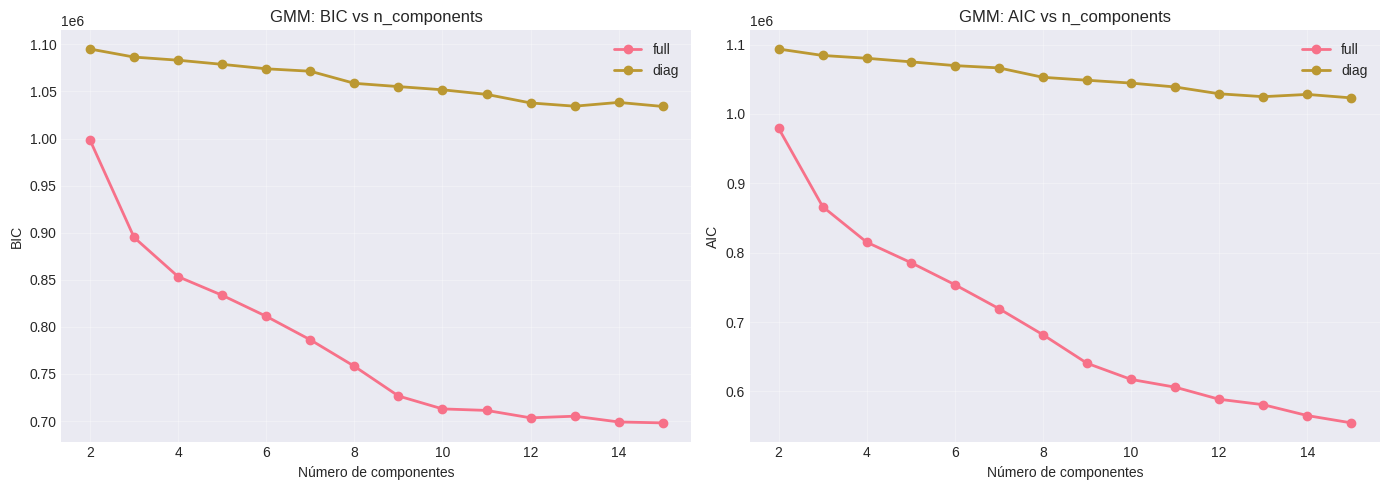


→ Mejor GMM por BIC:
  n_components=15, cov_type=full
  BIC=698029.3, AIC=554622.8
  ARI=0.422, NMI=0.626

→ Mejor GMM por ARI:
  n_components=11, cov_type=full
  BIC=711275.3, AIC=606112.4
  ARI=0.493, NMI=0.642


In [24]:
# BIC/AIC vs n_components
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for cov_type in PARAMS['gmm_covariance_types']:
    data = df_gmm[df_gmm['covariance_type'] == cov_type]
    axes[0].plot(data['n_components'], data['bic'], 'o-', label=cov_type, linewidth=2)
    axes[1].plot(data['n_components'], data['aic'], 'o-', label=cov_type, linewidth=2)

axes[0].set_xlabel('Número de componentes')
axes[0].set_ylabel('BIC')
axes[0].set_title('GMM: BIC vs n_components')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Número de componentes')
axes[1].set_ylabel('AIC')
axes[1].set_title('GMM: AIC vs n_components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar mejor modelo
best_gmm_bic = df_gmm.loc[df_gmm['bic'].idxmin()]
best_gmm_ari = df_gmm.loc[df_gmm['ari'].idxmax()]

print(f"\n→ Mejor GMM por BIC:")
print(f"  n_components={best_gmm_bic['n_components']}, cov_type={best_gmm_bic['covariance_type']}")
print(f"  BIC={best_gmm_bic['bic']:.1f}, AIC={best_gmm_bic['aic']:.1f}")
print(f"  ARI={best_gmm_bic['ari']:.3f}, NMI={best_gmm_bic['nmi']:.3f}")

print(f"\n→ Mejor GMM por ARI:")
print(f"  n_components={best_gmm_ari['n_components']}, cov_type={best_gmm_ari['covariance_type']}")
print(f"  BIC={best_gmm_ari['bic']:.1f}, AIC={best_gmm_ari['aic']:.1f}")
print(f"  ARI={best_gmm_ari['ari']:.3f}, NMI={best_gmm_ari['nmi']:.3f}")

In [25]:
# Ajustar mejor modelo GMM
gmm_final = GaussianMixture(n_components=int(best_gmm_ari['n_components']),
                            covariance_type=best_gmm_ari['covariance_type'],
                            random_state=42,
                            max_iter=200)
gmm_final.fit(X_pca)
labels_gmm_final = gmm_final.predict(X_pca)
probs_gmm = gmm_final.predict_proba(X_pca)

# Calcular entropía (ambigüedad)
entropy_gmm = -np.sum(probs_gmm * np.log(probs_gmm + 1e-10), axis=1)

print(f"\nEstadísticas de entropía GMM:")
print(f"  Media: {entropy_gmm.mean():.3f}")
print(f"  Mediana: {np.median(entropy_gmm):.3f}")
print(f"  Max: {entropy_gmm.max():.3f}")


Estadísticas de entropía GMM:
  Media: 0.009
  Mediana: -0.000
  Max: 0.693


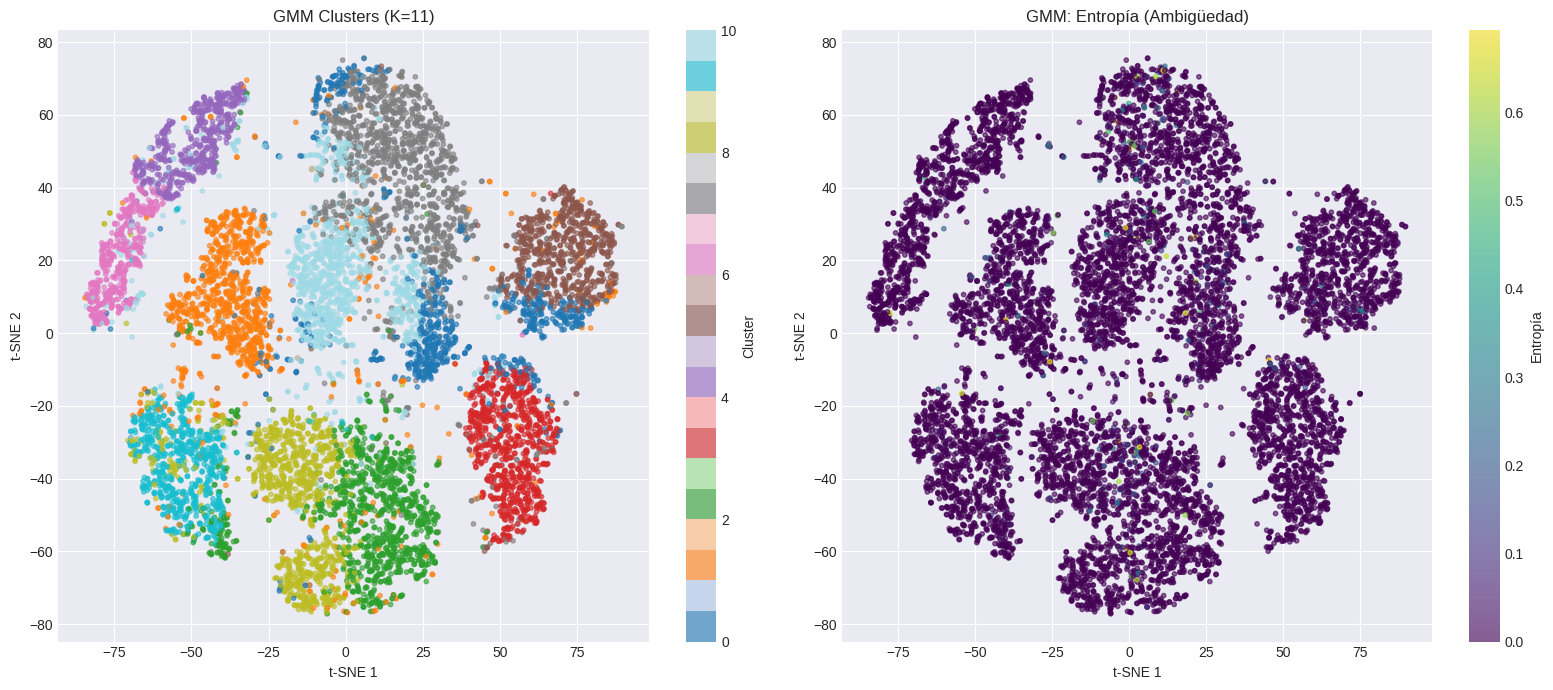

In [26]:
# Visualización GMM en t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Clusters
scatter1 = axes[0].scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                          c=labels_gmm_final, cmap='tab20', alpha=0.6, s=10)
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
axes[0].set_title(f'GMM Clusters (K={int(best_gmm_ari["n_components"])})')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Entropía (ambigüedad)
scatter2 = axes[1].scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                          c=entropy_gmm, cmap='viridis', alpha=0.6, s=10)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('GMM: Entropía (Ambigüedad)')
cbar = plt.colorbar(scatter2, ax=axes[1], label='Entropía')

plt.tight_layout()
plt.show()

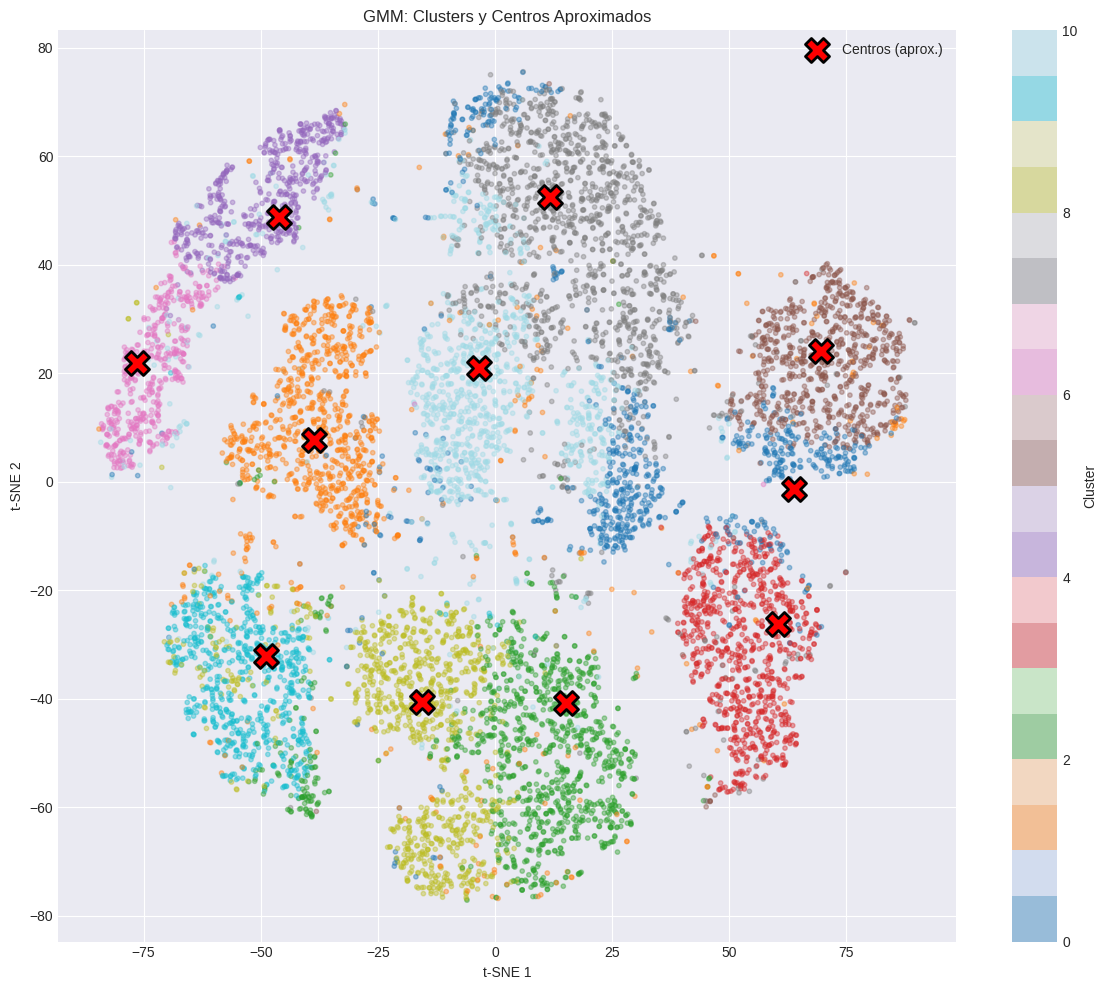

In [27]:
# Contornos de densidad GMM en t-SNE (proyección aproximada)
# Nota Importante: GMM fue ajustado en PCA, proyectamos centros a t-SNE para visualización

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

scatter = ax.scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                    c=labels_gmm_final, cmap='tab20', alpha=0.4, s=10)

# Proyectar centros de GMM a espacio t-SNE (aproximación)
# Usar t-SNE de los centros no es exacto, pero da idea visual
gmm_centers_pca = gmm_final.means_

# Encontrar puntos más cercanos a cada centro en PCA
closest_points_idx = []
for center in gmm_centers_pca:
    distances = np.linalg.norm(X_pca - center, axis=1)
    closest_points_idx.append(np.argmin(distances))

# Marcar centros aproximados en t-SNE
centers_tsne = X_tsne_base[closest_points_idx]
ax.scatter(centers_tsne[:, 0], centers_tsne[:, 1],
          c='red', marker='X', s=300, edgecolors='black', linewidths=2,
          label='Centros (aprox.)', zorder=5)

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title(f'GMM: Clusters y Centros Aproximados')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

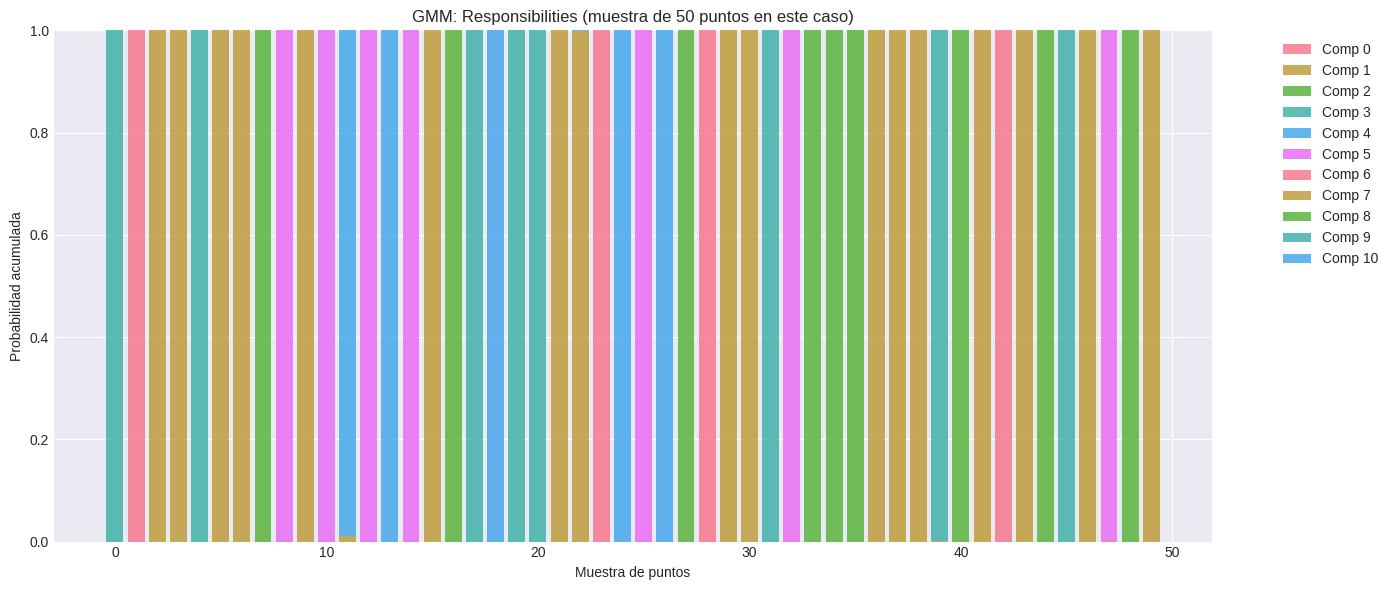

In [28]:
# Responsibilities: barras apiladas para muestra
sample_idx = np.random.choice(len(probs_gmm), 50, replace=False)
probs_sample = probs_gmm[sample_idx]

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
bottom = np.zeros(len(sample_idx))

for k in range(probs_sample.shape[1]):
    ax.bar(range(len(sample_idx)), probs_sample[:, k], bottom=bottom,
           label=f'Comp {k}', alpha=0.8)
    bottom += probs_sample[:, k]

ax.set_xlabel('Muestra de puntos')
ax.set_ylabel('Probabilidad acumulada')
ax.set_title('GMM: Responsibilities (muestra de 50 puntos en este caso)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

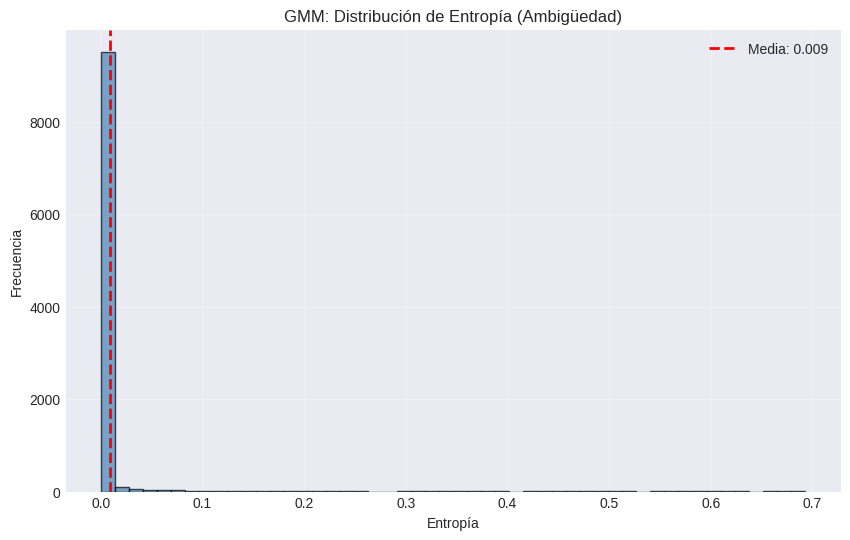


→ 10 puntos más ambiguos:
  1. Punto 9023: entropía=0.690, label real=8, GMM cluster=1
  2. Punto 4887: entropía=0.691, label real=2, GMM cluster=10
  3. Punto 9067: entropía=0.691, label real=5, GMM cluster=10
  4. Punto 1502: entropía=0.691, label real=4, GMM cluster=8
  5. Punto 2551: entropía=0.691, label real=3, GMM cluster=7
  6. Punto 991: entropía=0.692, label real=0, GMM cluster=0
  7. Punto 8939: entropía=0.692, label real=5, GMM cluster=7
  8. Punto 1389: entropía=0.693, label real=5, GMM cluster=7
  9. Punto 9430: entropía=0.693, label real=9, GMM cluster=2
  10. Punto 8267: entropía=0.693, label real=3, GMM cluster=7


In [29]:
# Histograma de entropía
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(entropy_gmm, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(entropy_gmm.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {entropy_gmm.mean():.3f}')
ax.set_xlabel('Entropía')
ax.set_ylabel('Frecuencia')
ax.set_title('GMM: Distribución de Entropía (Ambigüedad)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Identificar puntos más ambiguos
most_ambiguous_idx = np.argsort(entropy_gmm)[-10:]
print(f"\n→ 10 puntos más ambiguos:")
for i, idx in enumerate(most_ambiguous_idx):
    print(f"  {i+1}. Punto {idx}: entropía={entropy_gmm[idx]:.3f}, label real={y[idx]}, "
          f"GMM cluster={labels_gmm_final[idx]}")


EVALUACIÓN COMPARATIVA: DBSCAN vs GMM

=== COMPARACIÓN DBSCAN vs GMM ===
Método      ARI      NMI  Silhouette  Davies-Bouldin  N_Clusters  Tiempo (s)
DBSCAN 0.853243 0.859445   -0.138755        0.923386          46    0.055354
   GMM 0.493447 0.642360    0.057806        2.658006          11    8.628715


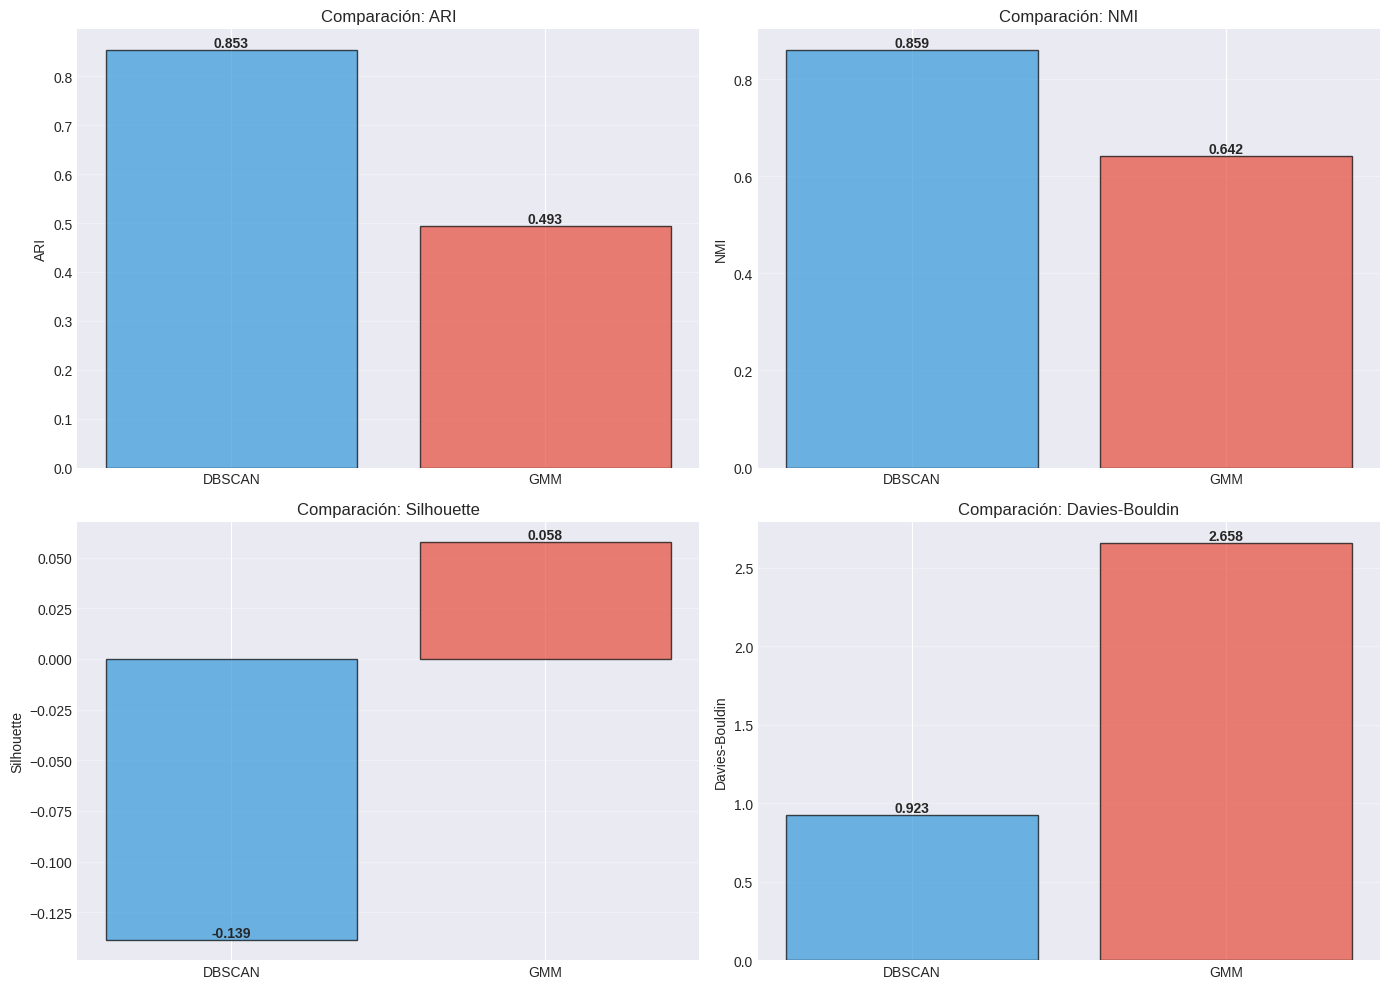

In [30]:
# ============================================================================
# 8. EVALUACIÓN COMPARATIVA Y MÉTRICAS
# ============================================================================
print("\n" + "="*70)
print("EVALUACIÓN COMPARATIVA: DBSCAN vs GMM")
print("="*70)

comparison_data = {
    'Método': ['DBSCAN', 'GMM'],
    'ARI': [best_dbscan['ari'], best_gmm_ari['ari']],
    'NMI': [best_dbscan['nmi'], best_gmm_ari['nmi']],
    'Silhouette': [best_dbscan['silhouette'], best_gmm_ari['silhouette']],
    'Davies-Bouldin': [best_dbscan['davies_bouldin'], best_gmm_ari['davies_bouldin']],
    'N_Clusters': [int(best_dbscan['n_clusters']), int(best_gmm_ari['n_components'])],
    'Tiempo (s)': [best_dbscan['time'], best_gmm_ari['time']]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n=== COMPARACIÓN DBSCAN vs GMM ===")
print(df_comparison.to_string(index=False))

# Visualización de métricas comparativas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['ARI', 'NMI', 'Silhouette', 'Davies-Bouldin']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [best_dbscan[metric.lower().replace('-', '_')],
              best_gmm_ari[metric.lower().replace('-', '_')]]

    bars = ax.bar(['DBSCAN', 'GMM'], values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric)
    ax.set_title(f'Comparación: {metric}')
    ax.grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.3f}',
               ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [31]:
# Evaluación con múltiples semillas (reproducibilidad)
print("\n→ Evaluando estabilidad con múltiples semillas...")

multi_seed_results = []

for seed in PARAMS['seeds']:
    print(f"  Semilla: {seed}")
    set_seed(seed)

    # t-SNE con esta semilla
    tsne_temp = TSNE(n_components=2,
                    perplexity=PARAMS['tsne_perplexities'][0],
                    learning_rate=PARAMS['tsne_learning_rates'][0],
                    n_iter=PARAMS['tsne_n_iter'],
                    random_state=seed,
                    verbose=0)
    X_tsne_temp = tsne_temp.fit_transform(X_pca)

    # DBSCAN
    dbscan_temp = DBSCAN(eps=best_dbscan['eps'],
                        min_samples=int(best_dbscan['min_samples']))
    clusters_db_temp = dbscan_temp.fit_predict(X_tsne_temp)

    mask_inliers = clusters_db_temp != -1
    if mask_inliers.sum() > 0:
        ari_db = adjusted_rand_score(y[mask_inliers], clusters_db_temp[mask_inliers])
        nmi_db = normalized_mutual_info_score(y[mask_inliers], clusters_db_temp[mask_inliers])
        if len(np.unique(clusters_db_temp[mask_inliers])) > 1:
            sil_db = silhouette_score(X_tsne_temp[mask_inliers], clusters_db_temp[mask_inliers])
        else:
            sil_db = -1
    else:
        ari_db = nmi_db = sil_db = -1

    # GMM
    gmm_temp = GaussianMixture(n_components=int(best_gmm_ari['n_components']),
                              covariance_type=best_gmm_ari['covariance_type'],
                              random_state=seed,
                              max_iter=200)
    gmm_temp.fit(X_pca)
    labels_gmm_temp = gmm_temp.predict(X_pca)

    ari_gmm = adjusted_rand_score(y, labels_gmm_temp)
    nmi_gmm = normalized_mutual_info_score(y, labels_gmm_temp)
    if int(best_gmm_ari['n_components']) > 1:
        sil_gmm = silhouette_score(X_pca, labels_gmm_temp)
    else:
        sil_gmm = -1

    multi_seed_results.append({
        'seed': seed,
        'dbscan_ari': ari_db,
        'dbscan_nmi': nmi_db,
        'dbscan_sil': sil_db,
        'gmm_ari': ari_gmm,
        'gmm_nmi': nmi_gmm,
        'gmm_sil': sil_gmm
    })

df_seeds = pd.DataFrame(multi_seed_results)
print("\n✓ Evaluación multi-semilla completada")


→ Evaluando estabilidad con múltiples semillas...
  Semilla: 0
  Semilla: 42
  Semilla: 99
  Semilla: 123
  Semilla: 2025

✓ Evaluación multi-semilla completada


In [32]:
print("\n=== RESULTADOS POR SEMILLA ===")
print(df_seeds.to_string(index=False))

print("\n=== ESTADÍSTICAS AGREGADAS (Media ± Std) ===")
summary_stats = {
    'Métrica': ['ARI', 'NMI', 'Silhouette'],
    'DBSCAN': [
        f"{df_seeds['dbscan_ari'].mean():.3f} ± {df_seeds['dbscan_ari'].std():.3f}",
        f"{df_seeds['dbscan_nmi'].mean():.3f} ± {df_seeds['dbscan_nmi'].std():.3f}",
        f"{df_seeds['dbscan_sil'].mean():.3f} ± {df_seeds['dbscan_sil'].std():.3f}"
    ],
    'GMM': [
        f"{df_seeds['gmm_ari'].mean():.3f} ± {df_seeds['gmm_ari'].std():.3f}",
        f"{df_seeds['gmm_nmi'].mean():.3f} ± {df_seeds['gmm_nmi'].std():.3f}",
        f"{df_seeds['gmm_sil'].mean():.3f} ± {df_seeds['gmm_sil'].std():.3f}"
    ]
}
df_summary = pd.DataFrame(summary_stats)
print(df_summary.to_string(index=False))


=== RESULTADOS POR SEMILLA ===
 seed  dbscan_ari  dbscan_nmi  dbscan_sil  gmm_ari  gmm_nmi  gmm_sil
    0    0.847948    0.856988   -0.095267 0.499058 0.651172 0.058489
   42    0.853243    0.859445   -0.138755 0.493447 0.642360 0.057806
   99    0.856973    0.864030   -0.095795 0.500969 0.639082 0.054572
  123    0.852690    0.859256   -0.110050 0.412196 0.589730 0.056377
 2025    0.856793    0.863230   -0.127057 0.455935 0.631556 0.052826

=== ESTADÍSTICAS AGREGADAS (Media ± Std) ===
   Métrica         DBSCAN           GMM
       ARI  0.854 ± 0.004 0.472 ± 0.038
       NMI  0.861 ± 0.003 0.631 ± 0.024
Silhouette -0.113 ± 0.019 0.056 ± 0.002


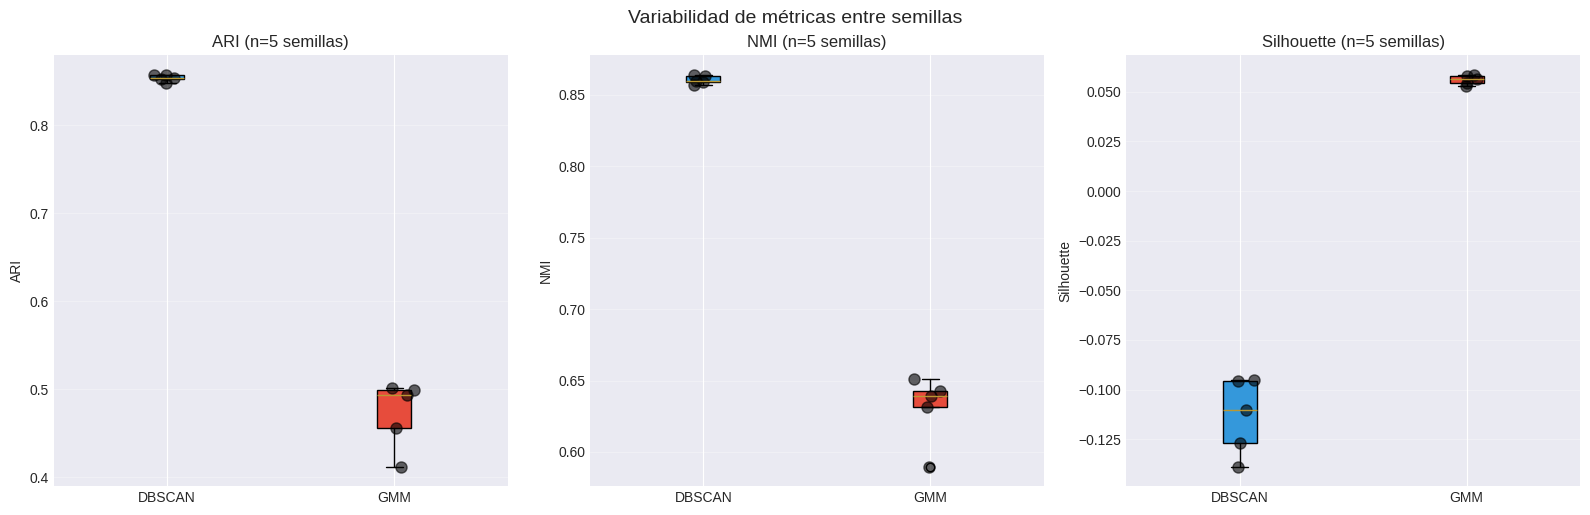

In [33]:
# Boxplots de métricas por método
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_to_plot = [
    ('ARI', 'dbscan_ari', 'gmm_ari'),
    ('NMI', 'dbscan_nmi', 'gmm_nmi'),
    ('Silhouette', 'dbscan_sil', 'gmm_sil')
]

for idx, (metric_name, db_col, gmm_col) in enumerate(metrics_to_plot):
    data_to_plot = [df_seeds[db_col], df_seeds[gmm_col]]
    bp = axes[idx].boxplot(data_to_plot, labels=['DBSCAN', 'GMM'], patch_artist=True)

    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')

    axes[idx].set_ylabel(metric_name)
    axes[idx].set_title(f'{metric_name} (n={len(PARAMS["seeds"])} semillas)')
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Añadir puntos individuales
    for i, data in enumerate(data_to_plot):
        x = np.random.normal(i+1, 0.04, size=len(data))
        axes[idx].plot(x, data, 'o', alpha=0.6, color='black', markersize=8)

plt.tight_layout()
plt.suptitle('Variabilidad de métricas entre semillas', y=1.02, fontsize=14)
plt.show()

In [34]:
print("\n=== TESTS ESTADÍSTICOS ===")

# Paired t-test para ARI
from scipy.stats import ttest_rel, wilcoxon

ari_dbscan = df_seeds['dbscan_ari'].values
ari_gmm = df_seeds['gmm_ari'].values

# Remover NaN si existen
valid_idx = ~(np.isnan(ari_dbscan) | np.isnan(ari_gmm))
ari_dbscan_valid = ari_dbscan[valid_idx]
ari_gmm_valid = ari_gmm[valid_idx]

if len(ari_dbscan_valid) > 1:
    t_stat, p_value_t = ttest_rel(ari_dbscan_valid, ari_gmm_valid)
    w_stat, p_value_w = wilcoxon(ari_dbscan_valid, ari_gmm_valid)

    print(f"\nPaired t-test (ARI):")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value_t:.4f}")
    print(f"  Significativo (α=0.05): {'Sí' if p_value_t < 0.05 else 'No'}")

    print(f"\nWilcoxon signed-rank test (ARI):")
    print(f"  W-statistic: {w_stat:.4f}")
    print(f"  p-value: {p_value_w:.4f}")
    print(f"  Significativo (α=0.05): {'Sí' if p_value_w < 0.05 else 'No'}")

    # Interpretación
    if p_value_t < 0.05:
        mejor = 'DBSCAN' if ari_dbscan_valid.mean() > ari_gmm_valid.mean() else 'GMM'
        print(f"\n→ Conclusión: {mejor} tiene significativamente mejor ARI (p < 0.05)")
    else:
        print(f"\n→ Conclusión: No hay diferencia significativa en ARI entre métodos (p >= 0.05)")
else:
    print("\nNo hay suficientes datos válidos para test estadístico")

# Similar para Silhouette
sil_dbscan = df_seeds['dbscan_sil'].values
sil_gmm = df_seeds['gmm_sil'].values

valid_idx_sil = ~(np.isnan(sil_dbscan) | np.isnan(sil_gmm))
sil_dbscan_valid = sil_dbscan[valid_idx_sil]
sil_gmm_valid = sil_gmm[valid_idx_sil]

if len(sil_dbscan_valid) > 1:
    t_stat_sil, p_value_t_sil = ttest_rel(sil_dbscan_valid, sil_gmm_valid)

    print(f"\nPaired t-test (Silhouette):")
    print(f"  t-statistic: {t_stat_sil:.4f}")
    print(f"  p-value: {p_value_t_sil:.4f}")
    print(f"  Significativo (α=0.05): {'Sí' if p_value_t_sil < 0.05 else 'No'}")

    if p_value_t_sil < 0.05:
        mejor = 'DBSCAN' if sil_dbscan_valid.mean() > sil_gmm_valid.mean() else 'GMM'
        print(f"\n→ Conclusión: {mejor} tiene significativamente mejor Silhouette (p < 0.05)")
    else:
        print(f"\n→ Conclusión: No hay diferencia significativa en Silhouette (p >= 0.05)")


=== TESTS ESTADÍSTICOS ===

Paired t-test (ARI):
  t-statistic: 21.9377
  p-value: 0.0000
  Significativo (α=0.05): Sí

Wilcoxon signed-rank test (ARI):
  W-statistic: 0.0000
  p-value: 0.0625
  Significativo (α=0.05): No

→ Conclusión: DBSCAN tiene significativamente mejor ARI (p < 0.05)

Paired t-test (Silhouette):
  t-statistic: -19.8036
  p-value: 0.0000
  Significativo (α=0.05): Sí

→ Conclusión: GMM tiene significativamente mejor Silhouette (p < 0.05)



VISUALIZACIONES DE DIAGNÓSTICO

→ Matriz de confusión GMM vs etiquetas reales...


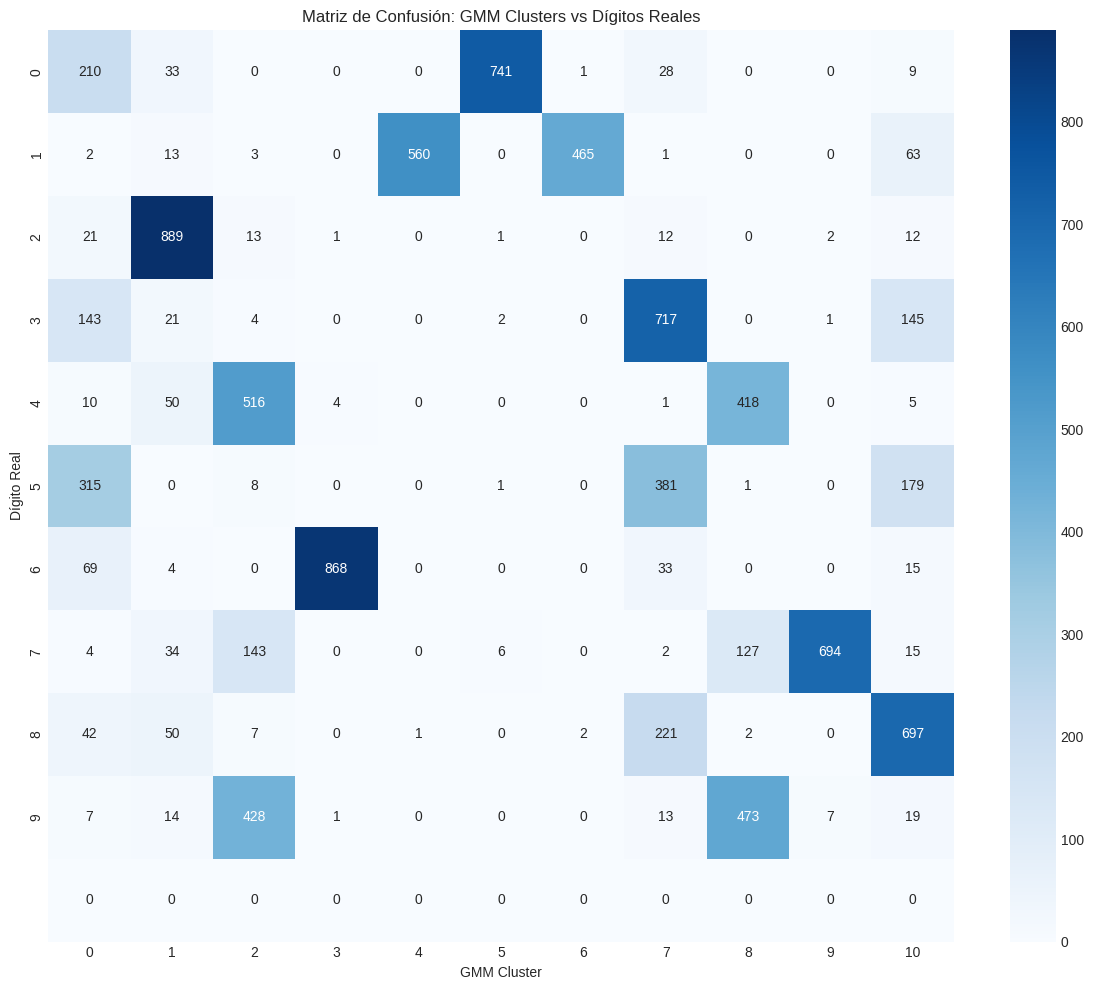

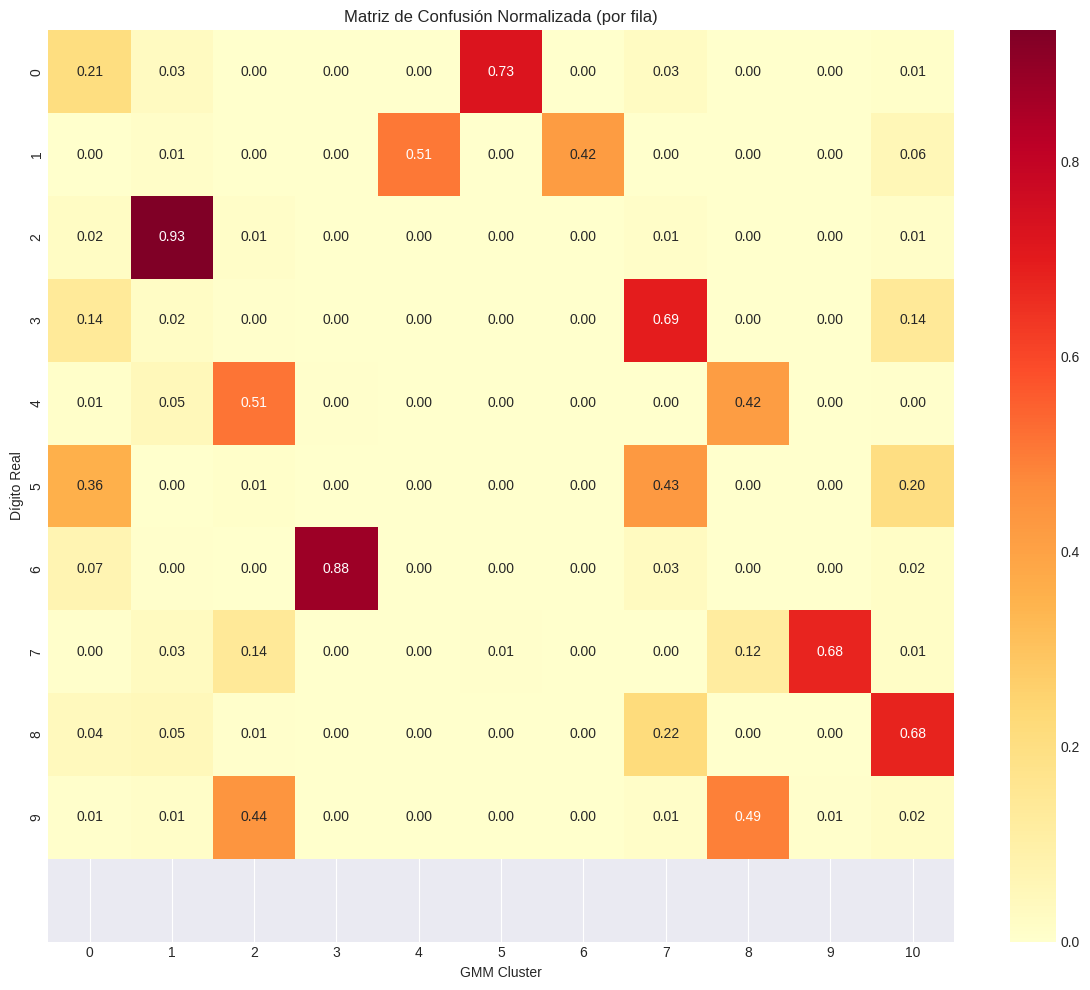

In [35]:
# ============================================================================
# 9. VISUALIZACIONES DE DIAGNÓSTICO ADICIONALES
# ============================================================================
print("\n" + "="*70)
print("VISUALIZACIONES DE DIAGNÓSTICO")
print("="*70)

# Matriz de confusión GMM
print("\n→ Matriz de confusión GMM vs etiquetas reales...")

conf_matrix = confusion_matrix(y, labels_gmm_final)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=range(int(best_gmm_ari['n_components'])),
            yticklabels=range(10))
ax.set_xlabel('GMM Cluster')
ax.set_ylabel('Dígito Real')
ax.set_title('Matriz de Confusión: GMM Clusters vs Dígitos Reales')
plt.tight_layout()
plt.show()

# Normalizada por filas
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax,
            xticklabels=range(int(best_gmm_ari['n_components'])),
            yticklabels=range(10))
ax.set_xlabel('GMM Cluster')
ax.set_ylabel('Dígito Real')
ax.set_title('Matriz de Confusión Normalizada (por fila)')
plt.tight_layout()
plt.show()


→ Generando Silhouette per sample plot...


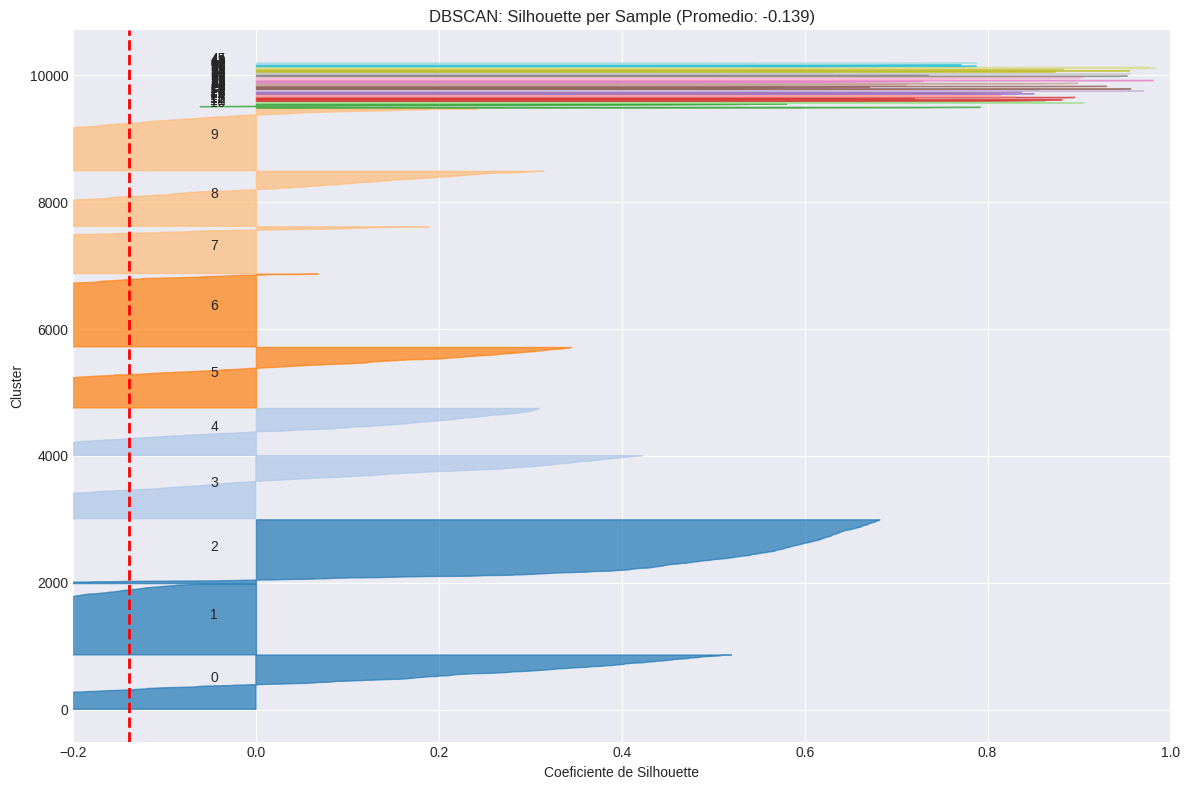

In [36]:
print("\n→ Generando Silhouette per sample plot...")

# Para DBSCAN
mask_inliers_best = clusters_dbscan != -1
if mask_inliers_best.sum() > 0 and len(np.unique(clusters_dbscan[mask_inliers_best])) > 1:
    from sklearn.metrics import silhouette_samples

    sil_samples_db = silhouette_samples(X_tsne_base[mask_inliers_best],
                                        clusters_dbscan[mask_inliers_best])

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    y_lower = 10
    unique_clusters = np.unique(clusters_dbscan[mask_inliers_best])

    for cluster in sorted(unique_clusters):
        cluster_sil_values = sil_samples_db[clusters_dbscan[mask_inliers_best] == cluster]
        cluster_sil_values.sort()

        size_cluster = cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster

        color = plt.cm.tab20(cluster / len(unique_clusters))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, cluster_sil_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    ax.set_xlabel('Coeficiente de Silhouette')
    ax.set_ylabel('Cluster')
    ax.set_title(f'DBSCAN: Silhouette per Sample (Promedio: {sil_samples_db.mean():.3f})')
    ax.axvline(x=sil_samples_db.mean(), color='red', linestyle='--', linewidth=2)
    ax.set_xlim([-0.2, 1])
    plt.tight_layout()
    plt.show()

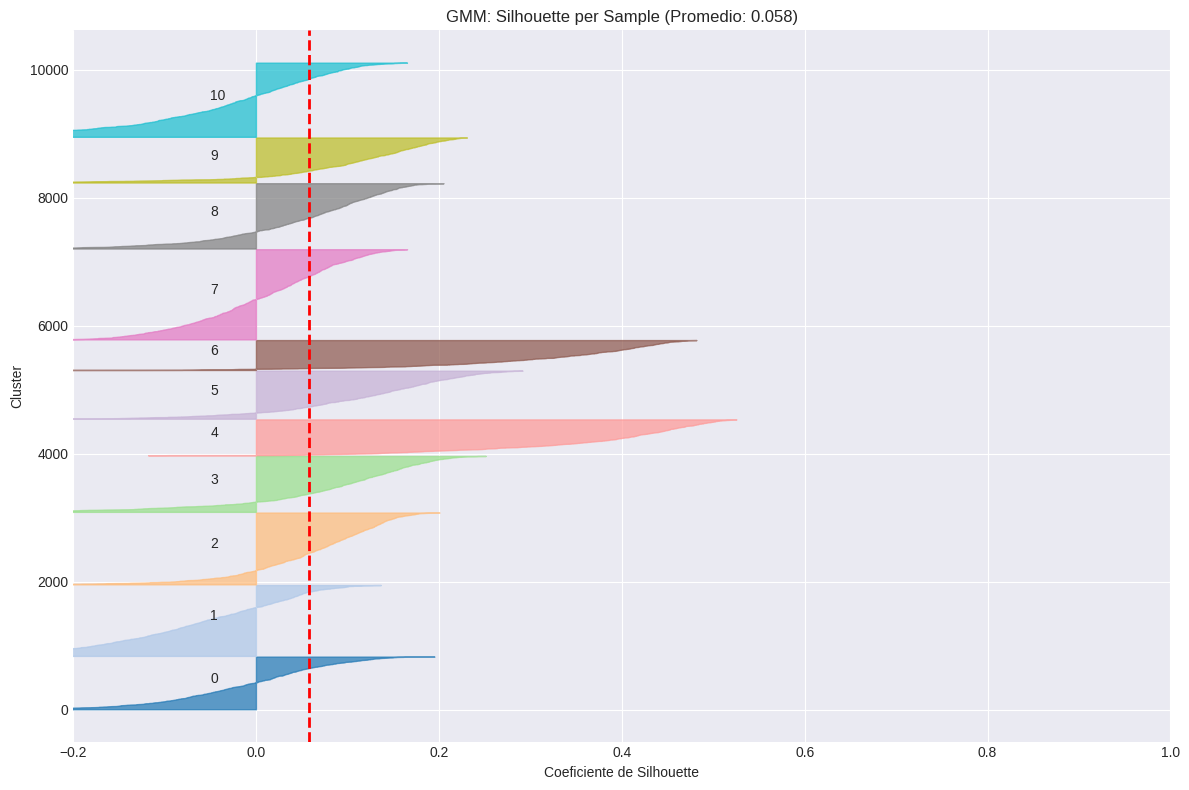

In [37]:
# Para GMM
if int(best_gmm_ari['n_components']) > 1:
    sil_samples_gmm = silhouette_samples(X_pca, labels_gmm_final)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    y_lower = 10
    unique_clusters_gmm = np.unique(labels_gmm_final)

    for cluster in sorted(unique_clusters_gmm):
        cluster_sil_values = sil_samples_gmm[labels_gmm_final == cluster]
        cluster_sil_values.sort()

        size_cluster = cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster

        color = plt.cm.tab20(cluster / len(unique_clusters_gmm))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, cluster_sil_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    ax.set_xlabel('Coeficiente de Silhouette')
    ax.set_ylabel('Cluster')
    ax.set_title(f'GMM: Silhouette per Sample (Promedio: {sil_samples_gmm.mean():.3f})')
    ax.axvline(x=sil_samples_gmm.mean(), color='red', linestyle='--', linewidth=2)
    ax.set_xlim([-0.2, 1])
    plt.tight_layout()
    plt.show()

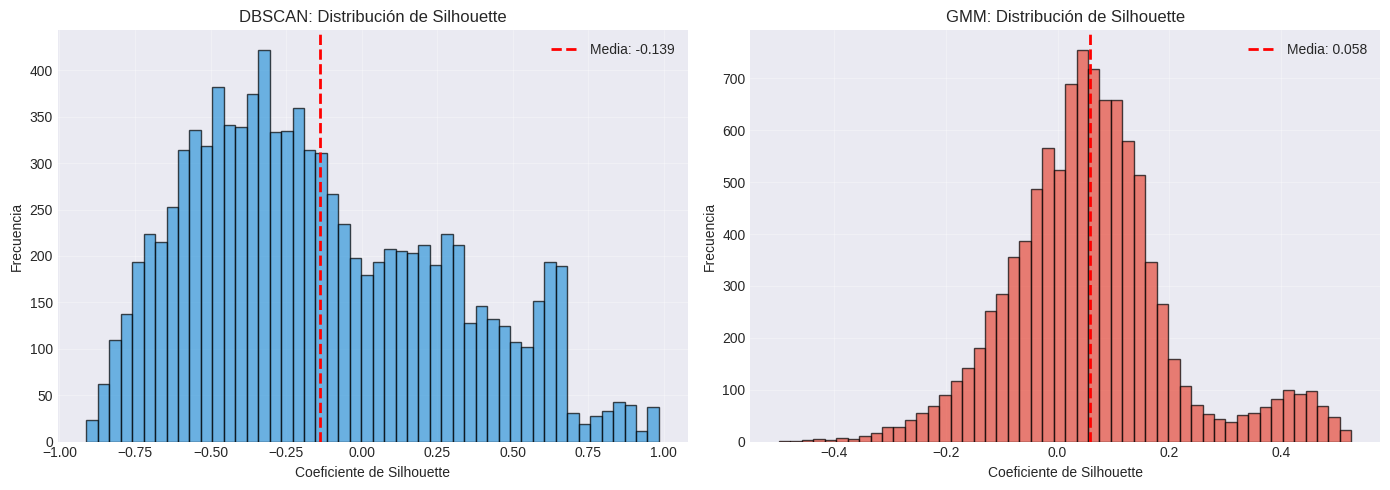

In [38]:
# Histogramas de Silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if mask_inliers_best.sum() > 0:
    axes[0].hist(sil_samples_db, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
    axes[0].axvline(sil_samples_db.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {sil_samples_db.mean():.3f}')
    axes[0].set_xlabel('Coeficiente de Silhouette')
    axes[0].set_ylabel('Frecuencia')
    axes[0].set_title('DBSCAN: Distribución de Silhouette')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

if int(best_gmm_ari['n_components']) > 1:
    axes[1].hist(sil_samples_gmm, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[1].axvline(sil_samples_gmm.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {sil_samples_gmm.mean():.3f}')
    axes[1].set_xlabel('Coeficiente de Silhouette')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('GMM: Distribución de Silhouette')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

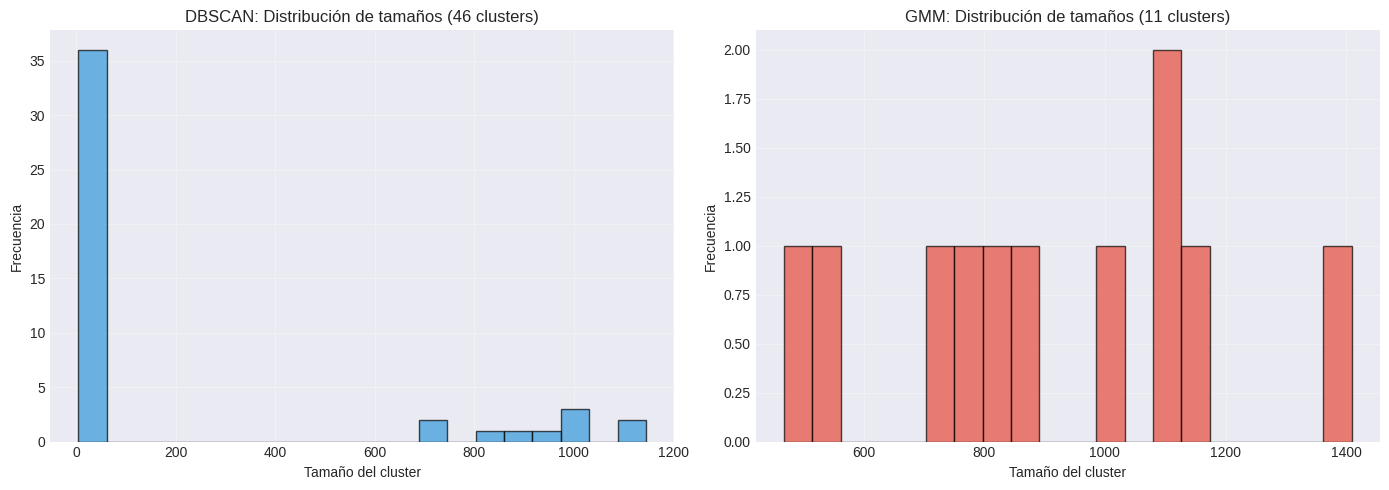

In [39]:
# Histograma de tamaños de clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DBSCAN
cluster_counts_db = Counter(clusters_dbscan[clusters_dbscan != -1])
axes[0].hist(list(cluster_counts_db.values()), bins=20, color='#3498db',
            alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Tamaño del cluster')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'DBSCAN: Distribución de tamaños ({len(cluster_counts_db)} clusters)')
axes[0].grid(True, alpha=0.3)

# GMM
cluster_counts_gmm = Counter(labels_gmm_final)
axes[1].hist(list(cluster_counts_gmm.values()), bins=20, color='#e74c3c',
            alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Tamaño del cluster')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'GMM: Distribución de tamaños ({len(cluster_counts_gmm)} clusters)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


→ Generando dendrograma (muestra de 1000 puntos en esta implementacion)...


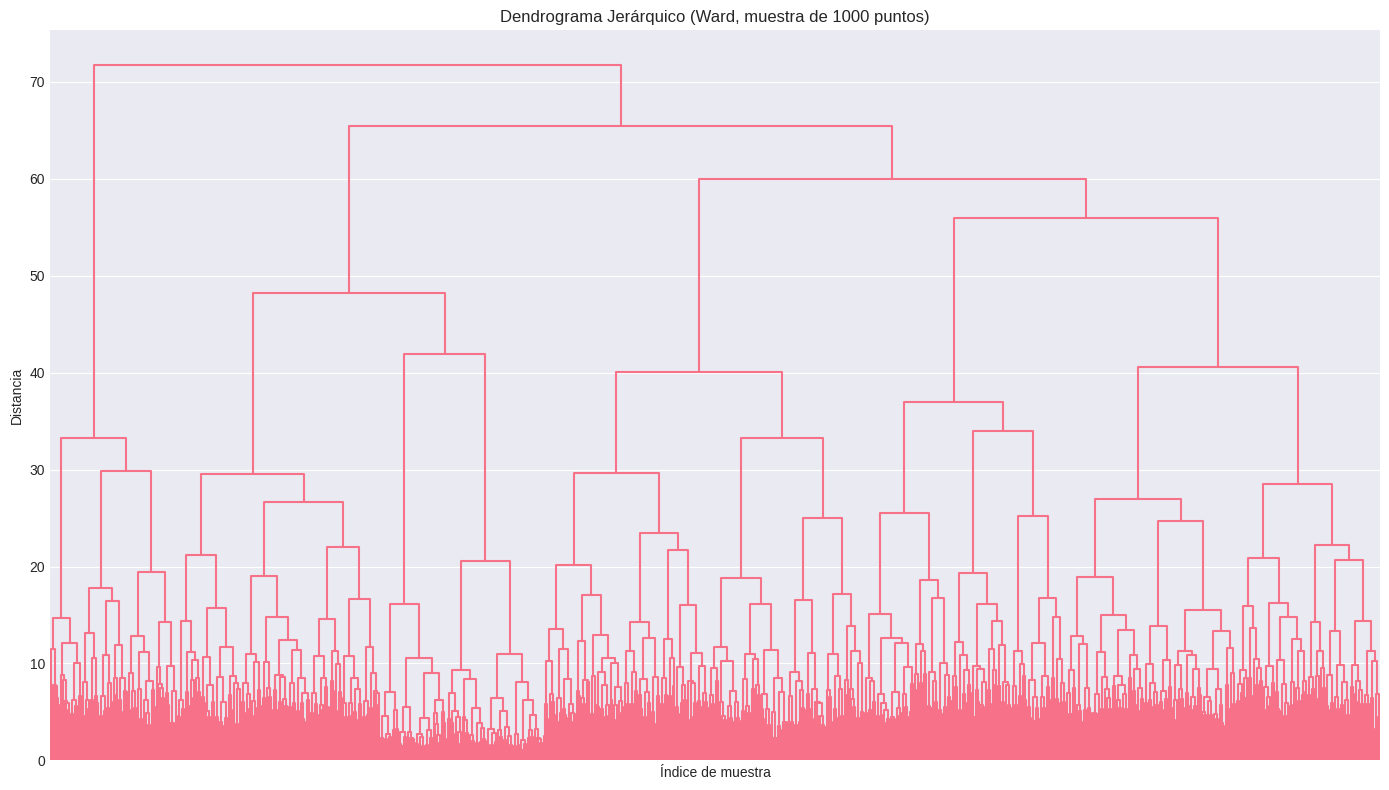

In [40]:
# Dendrograma (muestra limitada)
print("\n→ Generando dendrograma (muestra de 1000 puntos en esta implementacion)...")

sample_size_dend = 1000
sample_idx_dend = np.random.choice(len(X_pca), sample_size_dend, replace=False)
X_sample_dend = X_pca[sample_idx_dend]
y_sample_dend = y[sample_idx_dend]

# Calcular linkage
linkage_matrix = linkage(X_sample_dend, method='ward')

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=0)
ax.set_xlabel('Índice de muestra')
ax.set_ylabel('Distancia')
ax.set_title('Dendrograma Jerárquico (Ward, muestra de 1000 puntos)')
plt.tight_layout()
plt.show()

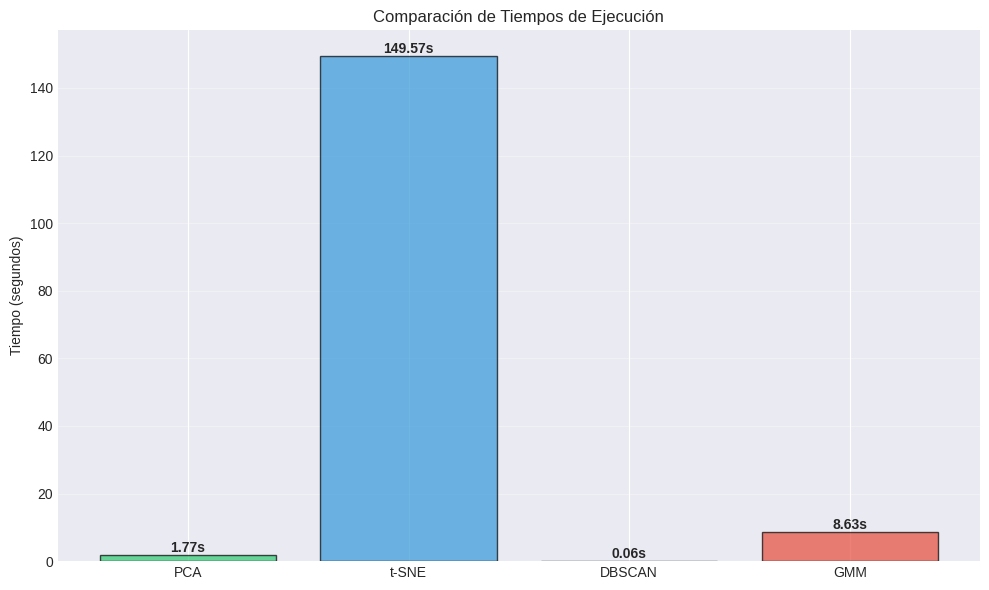


Tiempos de ejecución:
  PCA: 1.77s
  t-SNE: 149.57s
  DBSCAN: 0.06s
  GMM: 8.63s


In [41]:
# Comparación tiempos de ejecución
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

methods = ['PCA', 't-SNE', 'DBSCAN', 'GMM']
times = [
    time_pca if PARAMS['use_pca'] else 0,
    tsne_times[base_key],
    best_dbscan['time'],
    best_gmm_ari['time']
]

bars = ax.bar(methods, times, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'],
             alpha=0.7, edgecolor='black')
ax.set_ylabel('Tiempo (segundos)')
ax.set_title('Comparación de Tiempos de Ejecución')
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{time:.2f}s',
           ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTiempos de ejecución:")
print(f"  PCA: {time_pca:.2f}s" if PARAMS['use_pca'] else "  PCA: N/A")
print(f"  t-SNE: {tsne_times[base_key]:.2f}s")
print(f"  DBSCAN: {best_dbscan['time']:.2f}s")
print(f"  GMM: {best_gmm_ari['time']:.2f}s")


CASOS DE ESTUDIO

Ejemplos de puntos ambiguos (alta entropía GMM)...


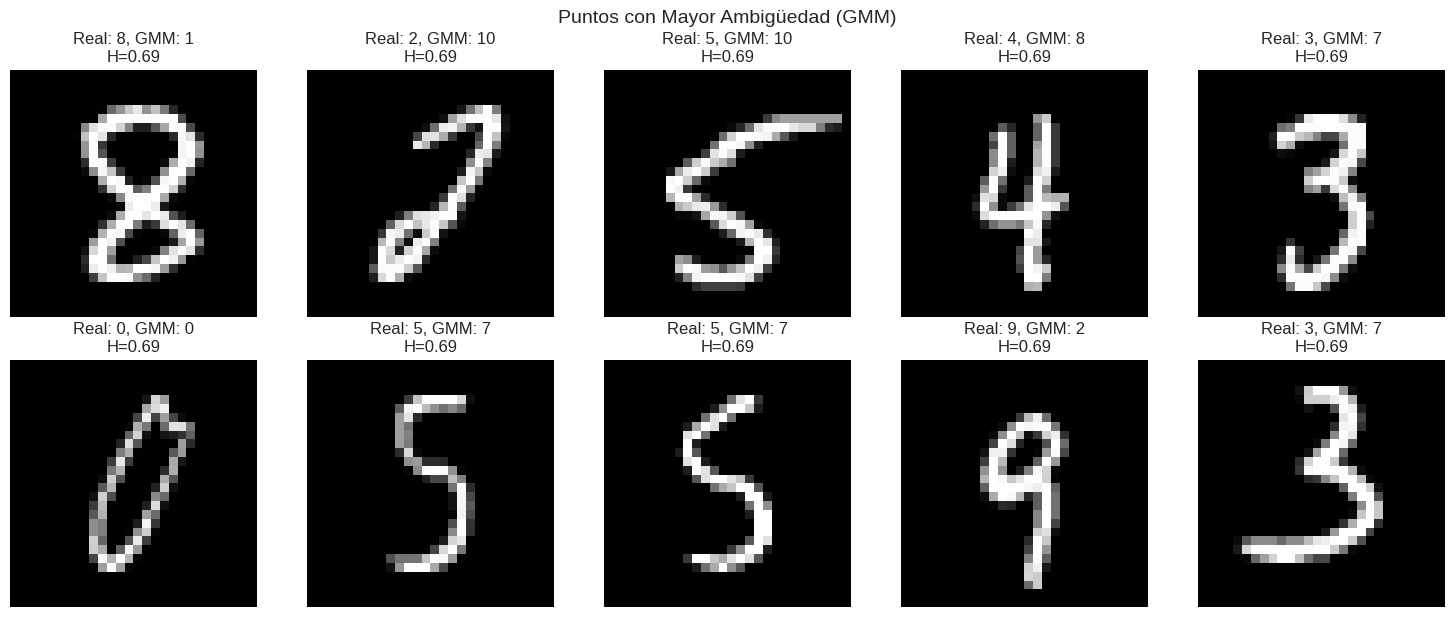

In [42]:
# ============================================================================
# 10. CASOS DE ESTUDIO / EJEMPLOS
# ============================================================================
print("\n" + "="*70)
print("CASOS DE ESTUDIO")
print("="*70)

# Puntos con alta ambigüedad (GMM)
print("\nEjemplos de puntos ambiguos (alta entropía GMM)...")

n_examples = min(10, len(most_ambiguous_idx))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(most_ambiguous_idx[:n_examples]):
    axes[i].imshow(X_raw[idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Real: {y[idx]}, GMM: {labels_gmm_final[idx]}\nH={entropy_gmm[idx]:.2f}')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Puntos con Mayor Ambigüedad (GMM)', y=1.02, fontsize=14)
plt.show()


Ejemplos de outliers (DBSCAN): 263 detectados


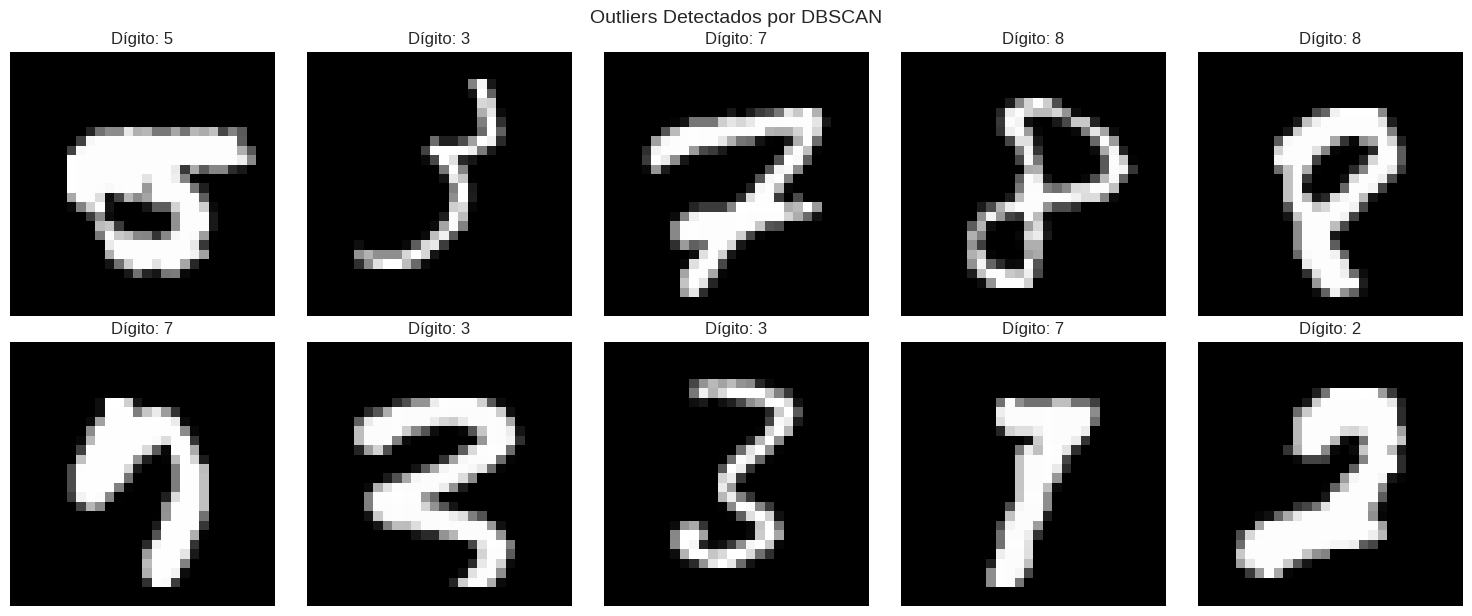

In [43]:
# Outliers detectados por DBSCAN
outlier_indices = np.where(clusters_dbscan == -1)[0]
print(f"\nEjemplos de outliers (DBSCAN): {len(outlier_indices)} detectados")

if len(outlier_indices) > 0:
    n_outliers_show = min(10, len(outlier_indices))
    sample_outliers = np.random.choice(outlier_indices, n_outliers_show, replace=False)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(sample_outliers):
        axes[i].imshow(X_raw[idx].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Dígito: {y[idx]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Outliers Detectados por DBSCAN', y=1.02, fontsize=14)
    plt.show()


Mosaicos de ejemplos por cluster (GMM)...

  Cluster 0: 823 puntos
    Distribución: {np.uint8(0): 210, np.uint8(1): 2, np.uint8(2): 21, np.uint8(3): 143, np.uint8(4): 10, np.uint8(5): 315, np.uint8(6): 69, np.uint8(7): 4, np.uint8(8): 42, np.uint8(9): 7}


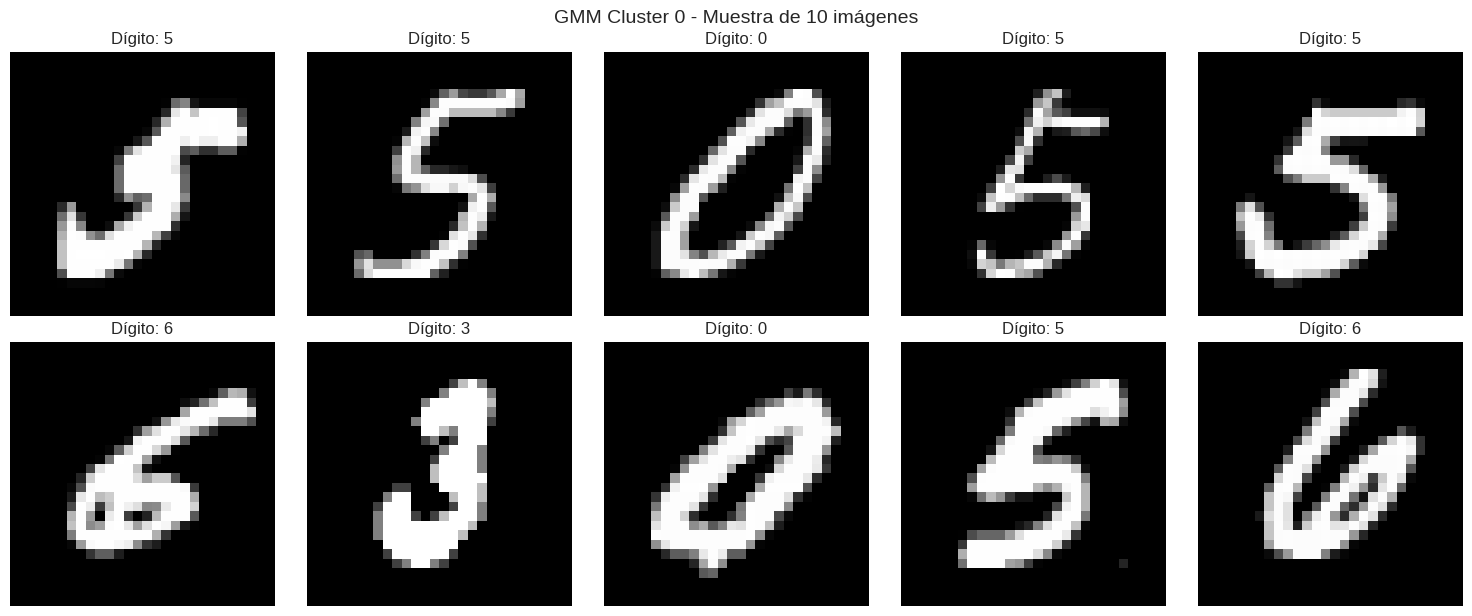


  Cluster 1: 1108 puntos
    Distribución: {np.uint8(0): 33, np.uint8(1): 13, np.uint8(2): 889, np.uint8(3): 21, np.uint8(4): 50, np.uint8(6): 4, np.uint8(7): 34, np.uint8(8): 50, np.uint8(9): 14}


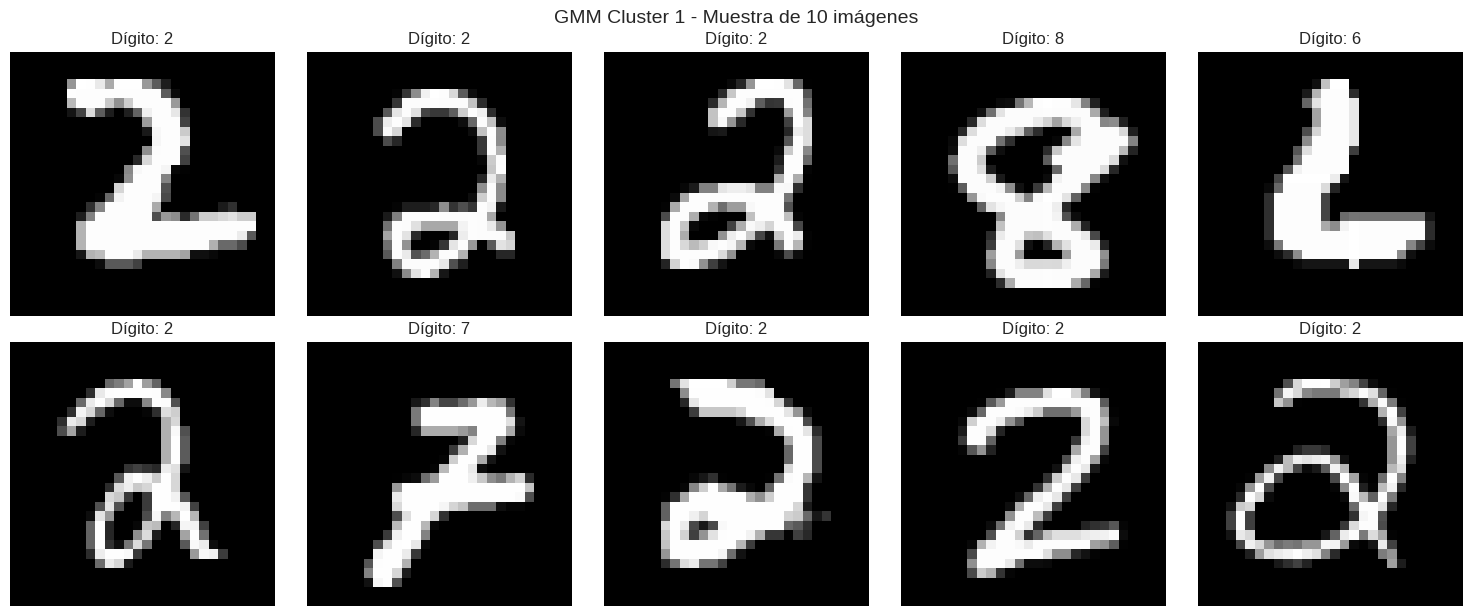


  Cluster 2: 1122 puntos
    Distribución: {np.uint8(1): 3, np.uint8(2): 13, np.uint8(3): 4, np.uint8(4): 516, np.uint8(5): 8, np.uint8(7): 143, np.uint8(8): 7, np.uint8(9): 428}


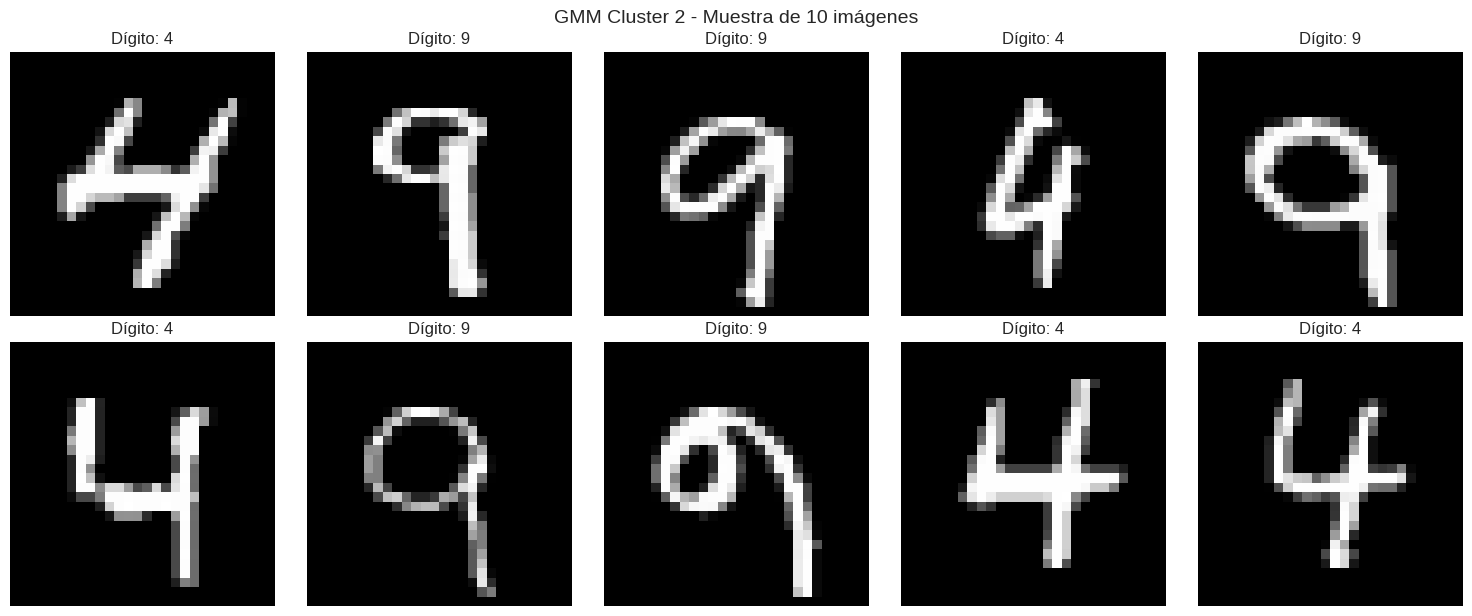


  Cluster 3: 874 puntos
    Distribución: {np.uint8(2): 1, np.uint8(4): 4, np.uint8(6): 868, np.uint8(9): 1}


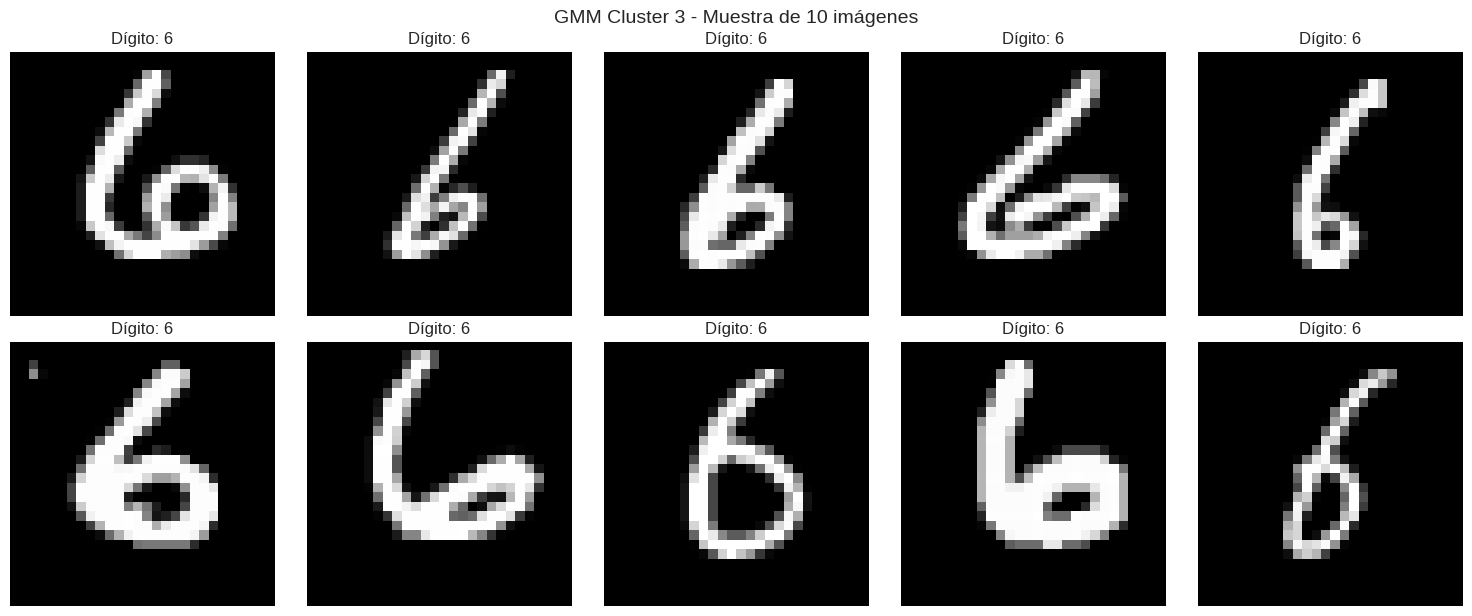


  Cluster 4: 561 puntos
    Distribución: {np.uint8(1): 560, np.uint8(8): 1}


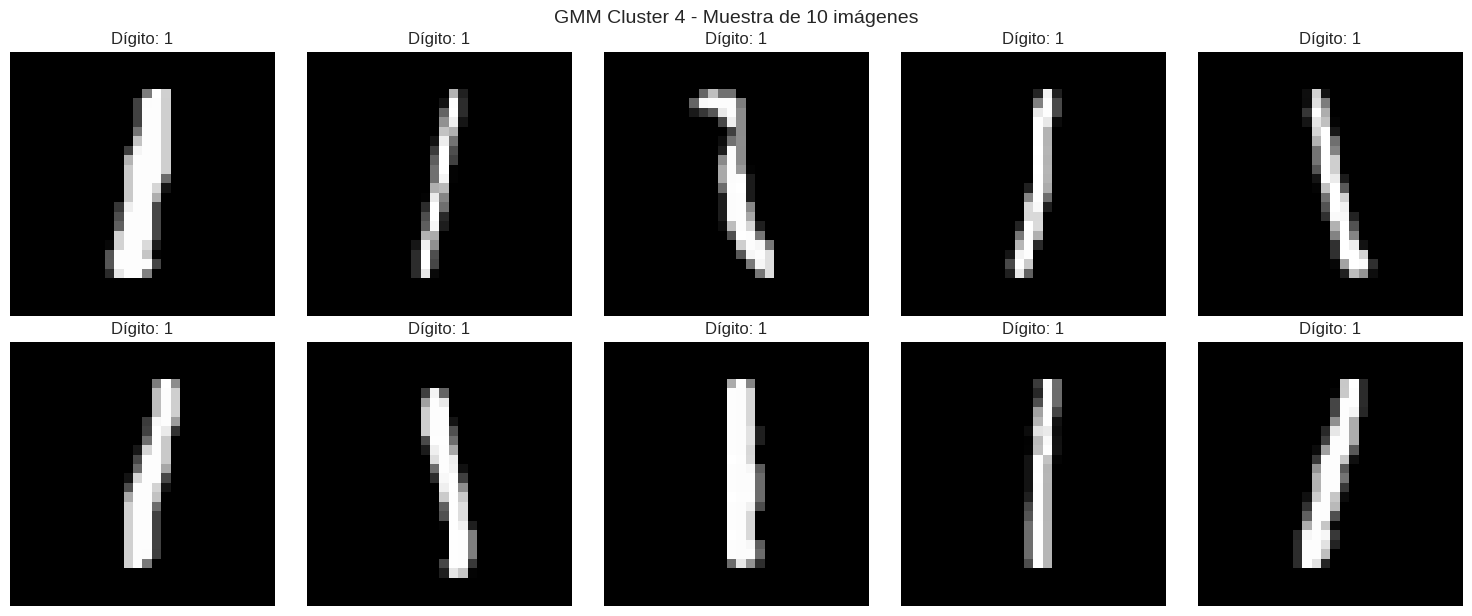

In [44]:
# Mosaicos por cluster (GMM)
print("\nMosaicos de ejemplos por cluster (GMM)...")

n_clusters_show = min(5, int(best_gmm_ari['n_components']))
images_per_cluster = min(10, PARAMS['sample_images_per_cluster'])

for cluster_id in range(n_clusters_show):
    cluster_indices = np.where(labels_gmm_final == cluster_id)[0]

    if len(cluster_indices) == 0:
        continue

    print(f"\n  Cluster {cluster_id}: {len(cluster_indices)} puntos")

    # Mostrar distribución de dígitos reales en este cluster
    digits_in_cluster = y[cluster_indices]
    digit_counts = Counter(digits_in_cluster)
    print(f"    Distribución: {dict(sorted(digit_counts.items()))}")

    # Tomar muestra
    sample_size = min(images_per_cluster, len(cluster_indices))
    sample_indices = np.random.choice(cluster_indices, sample_size, replace=False)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(sample_indices):
        axes[i].imshow(X_raw[idx].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Dígito: {y[idx]}')
        axes[i].axis('off')

    # Ocultar ejes no usados
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f'GMM Cluster {cluster_id} - Muestra de {sample_size} imágenes',
                y=1.02, fontsize=14)
    plt.show()


Análisis de confusiones comunes...

Pares de dígitos con mayor confusión (GMM):
  1 ↔ 8: 7 clusters compartidos
  2 ↔ 3: 7 clusters compartidos
  2 ↔ 7: 7 clusters compartidos
  2 ↔ 9: 7 clusters compartidos
  3 ↔ 7: 7 clusters compartidos

→ Mostrando ejemplos de 1 vs 8...


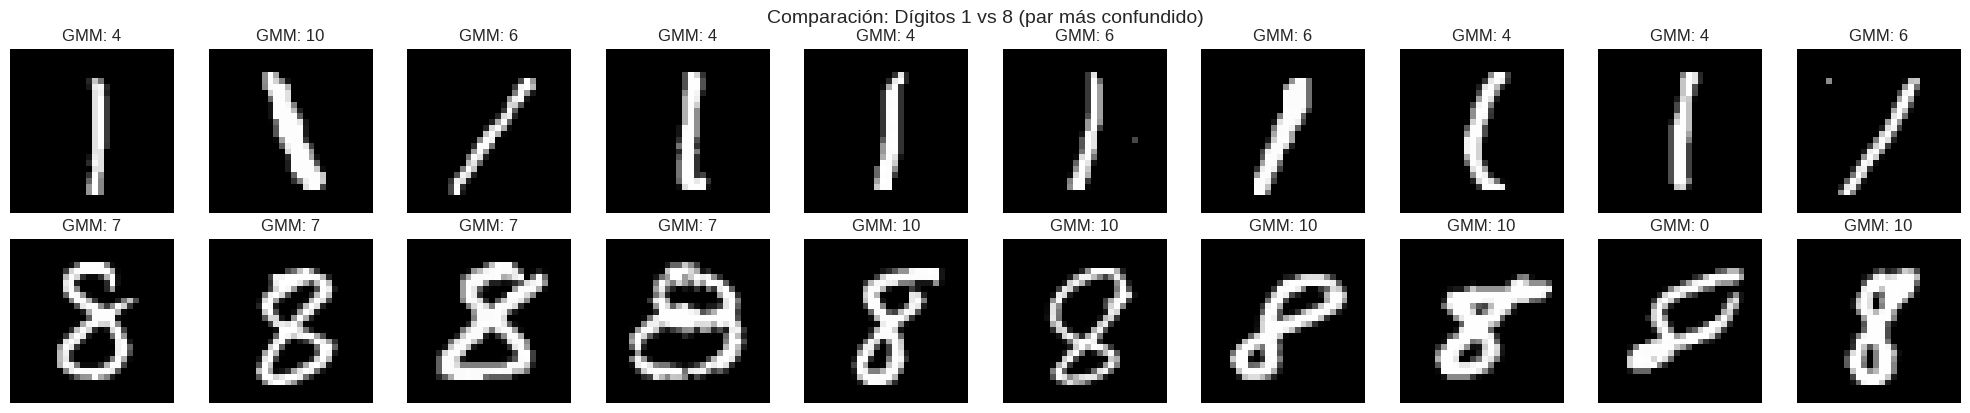

In [47]:
print("\nAnálisis de confusiones comunes...")

confusion_pairs = []
for i in range(10):
    for j in range(i+1, 10):
        # Contar cuántos dígitos i están en clusters dominados por j y viceversa
        digit_i_indices = np.where(y == i)[0]
        digit_j_indices = np.where(y == j)[0]

        clusters_i = labels_gmm_final[digit_i_indices]
        clusters_j = labels_gmm_final[digit_j_indices]

        # Solapamiento de clusters
        overlap = len(set(clusters_i) & set(clusters_j))
        if overlap > 0:
            confusion_pairs.append((i, j, overlap))

# Ordenar por solapamiento
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\nPares de dígitos con mayor confusión (GMM):")
for digit1, digit2, overlap in confusion_pairs[:5]:
    print(f"  {digit1} ↔ {digit2}: {overlap} clusters compartidos")

# Mostrar ejemplos del par más confundido
if len(confusion_pairs) > 0:
    digit1, digit2, _ = confusion_pairs[0]
    print(f"\n→ Mostrando ejemplos de {digit1} vs {digit2}...")

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))

    # Primera fila: dígito 1
    digit1_indices = np.where(y == digit1)[0]
    sample1 = np.random.choice(digit1_indices, min(10, len(digit1_indices)), replace=False)
    for i, idx in enumerate(sample1):
        axes[0, i].imshow(X_raw[idx].reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'GMM: {labels_gmm_final[idx]}')
        axes[0, i].axis('off')

    # Segunda fila: dígito 2
    digit2_indices = np.where(y == digit2)[0]
    sample2 = np.random.choice(digit2_indices, min(10, len(digit2_indices)), replace=False)
    for i, idx in enumerate(sample2):
        axes[1, i].imshow(X_raw[idx].reshape(28, 28), cmap='gray')
        axes[1, i].set_title(f'GMM: {labels_gmm_final[idx]}')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel(f'Dígito {digit1}', fontsize=12, rotation=0, labelpad=40)
    axes[1, 0].set_ylabel(f'Dígito {digit2}', fontsize=12, rotation=0, labelpad=40)

    plt.tight_layout()
    plt.suptitle(f'Comparación: Dígitos {digit1} vs {digit2} (par más confundido)',
                y=1.02, fontsize=14)
    plt.show()

In [48]:
# ============================================================================
# 11. RESUMEN FINAL
# ============================================================================
print("\n" + "="*70)
print("RESUMEN FINAL Y CONCLUSIONES")
print("="*70)

# Tabla resumen final
final_summary = {
    'Aspecto': [
        'Método',
        'Configuración',
        'N° Clusters',
        'ARI (media±std)',
        'NMI (media±std)',
        'Silhouette (media±std)',
        'Davies-Bouldin',
        'Tiempo (s)',
        '% Outliers',
        'Convergencia'
    ],
    'DBSCAN': [
        'DBSCAN (densidad)',
        f'eps={best_dbscan["eps"]:.2f}, min_samples={int(best_dbscan["min_samples"])}',
        f'{int(best_dbscan["n_clusters"])}',
        f'{df_seeds["dbscan_ari"].mean():.3f} ± {df_seeds["dbscan_ari"].std():.3f}',
        f'{df_seeds["dbscan_nmi"].mean():.3f} ± {df_seeds["dbscan_nmi"].std():.3f}',
        f'{df_seeds["dbscan_sil"].mean():.3f} ± {df_seeds["dbscan_sil"].std():.3f}',
        f'{best_dbscan["davies_bouldin"]:.3f}',
        f'{best_dbscan["time"]:.2f}',
        f'{best_dbscan["pct_outliers"]:.1f}%',
        'N/A'
    ],
    'GMM': [
        'GMM/EM (probabilístico)',
        f'K={int(best_gmm_ari["n_components"])}, cov_type={best_gmm_ari["covariance_type"]}',
        f'{int(best_gmm_ari["n_components"])}',
        f'{df_seeds["gmm_ari"].mean():.3f} ± {df_seeds["gmm_ari"].std():.3f}',
        f'{df_seeds["gmm_nmi"].mean():.3f} ± {df_seeds["gmm_nmi"].std():.3f}',
        f'{df_seeds["gmm_sil"].mean():.3f} ± {df_seeds["gmm_sil"].std():.3f}',
        f'{best_gmm_ari["davies_bouldin"]:.3f}',
        f'{best_gmm_ari["time"]:.2f}',
        '0%',
        f'{"Sí" if best_gmm_ari["converged"] else "No"}'
    ]
}

df_final_summary = pd.DataFrame(final_summary)
print("\n=== TABLA RESUMEN COMPARATIVA ===")
print(df_final_summary.to_string(index=False))


RESUMEN FINAL Y CONCLUSIONES

=== TABLA RESUMEN COMPARATIVA ===
               Aspecto                  DBSCAN                     GMM
                Método       DBSCAN (densidad) GMM/EM (probabilístico)
         Configuración eps=2.00, min_samples=5     K=11, cov_type=full
           N° Clusters                      46                      11
       ARI (media±std)           0.854 ± 0.004           0.472 ± 0.038
       NMI (media±std)           0.861 ± 0.003           0.631 ± 0.024
Silhouette (media±std)          -0.113 ± 0.019           0.056 ± 0.002
        Davies-Bouldin                   0.923                   2.658
            Tiempo (s)                    0.06                    8.63
            % Outliers                    2.6%                      0%
          Convergencia                     N/A                      Sí


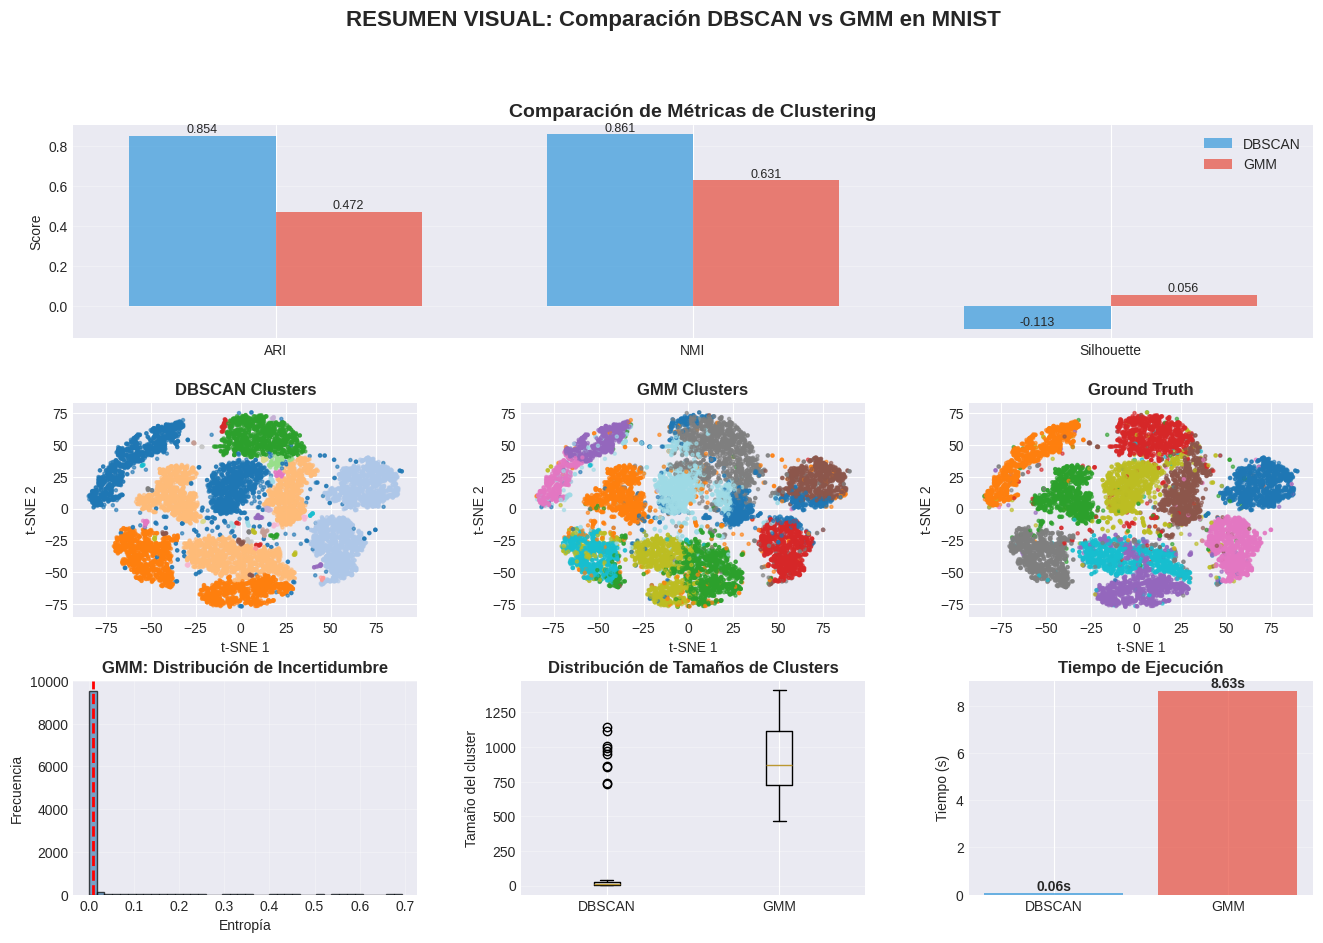

In [49]:
# Gráfico final resumen
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Comparación de métricas
ax1 = fig.add_subplot(gs[0, :])
metrics_names = ['ARI', 'NMI', 'Silhouette']
dbscan_vals = [df_seeds['dbscan_ari'].mean(), df_seeds['dbscan_nmi'].mean(),
               df_seeds['dbscan_sil'].mean()]
gmm_vals = [df_seeds['gmm_ari'].mean(), df_seeds['gmm_nmi'].mean(),
            df_seeds['gmm_sil'].mean()]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, dbscan_vals, width, label='DBSCAN', color='#3498db', alpha=0.7)
bars2 = ax1.bar(x + width/2, gmm_vals, width, label='GMM', color='#e74c3c', alpha=0.7)

ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas de Clustering', fontweight='bold', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. DBSCAN en t-SNE
ax2 = fig.add_subplot(gs[1, 0])
scatter2 = ax2.scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                      c=clusters_dbscan, cmap='tab20', alpha=0.6, s=5)
ax2.set_title('DBSCAN Clusters', fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

# 3. GMM en t-SNE
ax3 = fig.add_subplot(gs[1, 1])
scatter3 = ax3.scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                      c=labels_gmm_final, cmap='tab20', alpha=0.6, s=5)
ax3.set_title('GMM Clusters', fontweight='bold')
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')

# 4. Ground truth
ax4 = fig.add_subplot(gs[1, 2])
scatter4 = ax4.scatter(X_tsne_base[:, 0], X_tsne_base[:, 1],
                      c=y, cmap='tab10', alpha=0.6, s=5)
ax4.set_title('Ground Truth', fontweight='bold')
ax4.set_xlabel('t-SNE 1')
ax4.set_ylabel('t-SNE 2')

# 5. Distribución de entropía GMM
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(entropy_gmm, bins=40, color='steelblue', alpha=0.7, edgecolor='black')
ax5.axvline(entropy_gmm.mean(), color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Entropía')
ax5.set_ylabel('Frecuencia')
ax5.set_title('GMM: Distribución de Incertidumbre', fontweight='bold')
ax5.grid(True, alpha=0.3)

# 6. Tamaños de clusters
ax6 = fig.add_subplot(gs[2, 1])
cluster_sizes_db = list(Counter(clusters_dbscan[clusters_dbscan != -1]).values())
cluster_sizes_gmm = list(Counter(labels_gmm_final).values())
ax6.boxplot([cluster_sizes_db, cluster_sizes_gmm], labels=['DBSCAN', 'GMM'])
ax6.set_ylabel('Tamaño del cluster')
ax6.set_title('Distribución de Tamaños de Clusters', fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Tiempos
ax7 = fig.add_subplot(gs[2, 2])
times_methods = ['DBSCAN', 'GMM']
times_values = [best_dbscan['time'], best_gmm_ari['time']]
bars7 = ax7.bar(times_methods, times_values, color=['#3498db', '#e74c3c'], alpha=0.7)
ax7.set_ylabel('Tiempo (s)')
ax7.set_title('Tiempo de Ejecución', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')
for bar, time in zip(bars7, times_values):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
            f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.suptitle('RESUMEN VISUAL: Comparación DBSCAN vs GMM en MNIST',
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [50]:
print("\n" + "="*70)
print("Resultados")
print("="*70)

# Determinar método ganador
ari_winner = 'GMM' if df_seeds['gmm_ari'].mean() > df_seeds['dbscan_ari'].mean() else 'DBSCAN'
sil_winner = 'GMM' if df_seeds['gmm_sil'].mean() > df_seeds['dbscan_sil'].mean() else 'DBSCAN'
stability_winner = 'GMM' if df_seeds['gmm_ari'].std() < df_seeds['dbscan_ari'].std() else 'DBSCAN'

print(f"\nMÉTODO RECOMENDADO: {ari_winner}")
print(f"\nJustificación:")
print(f"  • Mejor ARI promedio: {ari_winner}")
print(f"  • Mejor Silhouette promedio: {sil_winner}")
print(f"  • Mayor estabilidad: {stability_winner}")

if ari_winner == 'GMM':
    print(f"\n  GMM muestra superioridad en:")
    print(f"  - Concordancia con etiquetas reales (ARI: {df_seeds['gmm_ari'].mean():.3f})")
    print(f"  - Consistencia entre ejecuciones (std: {df_seeds['gmm_ari'].std():.3f})")
else:
    print(f"\n  DBSCAN muestra superioridad en:")
    print(f"  - Concordancia con etiquetas reales (ARI: {df_seeds['dbscan_ari'].mean():.3f})")


Resultados

MÉTODO RECOMENDADO: DBSCAN

Justificación:
  • Mejor ARI promedio: DBSCAN
  • Mejor Silhouette promedio: GMM
  • Mayor estabilidad: DBSCAN

  DBSCAN muestra superioridad en:
  - Concordancia con etiquetas reales (ARI: 0.854)
